# Evaluation


## Setup

In [18]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch import nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import torch.nn.functional as F
from dataset import LTTDataset

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")

img_save_dir = 'graphics/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Add this import
import lpips
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import get_solvers, move_tensor_to_device, parse_arguments, set_seed_everything

from dataset import load_data_from_dir, LTTDataset
from latent_to_timestep_model import  Delta_LTT_model
from models import prepare_stuff
import torch.optim.lr_scheduler as lr_scheduler
from utils import visual


args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


## LD3 Best timesteps


In [ ]:
n3_params = torch.tensor([0.6048, 1.0274, 0.6334, 1.8439], device='cuda:0')
n5_params = torch.tensor([0.8088, 1.1801, 0.9390, 0.7322, 0.7591, 2.0050], device='cuda:0')
n7_params = torch.tensor([1.1434, 1.2401, 0.9985, 0.6071, 0.9339, 0.1873, 0.8551, 1.9311], device='cuda:0')
n10_params = torch.tensor([1.6245, 1.3128, 1.5374, 0.6975, 0.8498, 0.9843, 1.3483, 0.6511, 1.1129, 1.2806, 1.6264], device='cuda:0')


n3_params = F.softmax(n3_params, dim=0)
n5_params = F.softmax(n5_params, dim=0)
n7_params = F.softmax(n7_params, dim=0)
n10_params = F.softmax(n10_params, dim=0)

print(f"n3_params:\n{n3_params}")
print(f"n5_params:\n{n5_params}")
print(f"n7_params:\n{n7_params}")
print(f"n10_params:\n{n10_params}")

## LTT Model

In [ ]:
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt", 10
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt", 10

model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 10
model_path, steps  = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N7-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 7
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N5-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 5
# model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N3-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 3
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_batch3_moreData_N5-val50-train450-r5/final_ltt_model.pt", 5
without_dropout_model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_after_ltt_change_batch1_without_dropout_N5-val50-train450-r10/final_ltt_model.pt", 5
with_dropout_model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_after_ltt_change_batch1_with_dropout_N5-val50-train450-r10/final_ltt_model.pt", 5
trained_on_optimal_without_dropout, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs/RandomModels/model_lr0.0001_batch5_without_dropout.pth", 5
after_ltt_change, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_After_LTT_DatasetAdjustement_batch3_N5-val50-train450-r2/final_ltt_model.pt", 5

ltt_model = LTT_model(steps=steps)
state_dict = torch.load(trained_on_optimal_without_dropout, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

In [ ]:
params_list = ltt_model.forward(torch.stack(second_outputs)) 

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, steps+1)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(steps+1)])
sns.violinplot(data=params_list)
plt.show()


In [ ]:
params_list


### U-net encoding

In [ ]:
# Create a dictionary to store the output
hook_storage = {}

# Define the hook function using a closure
def get_hook(storage):
    def hook_fn(module, input, output):
        storage["unet_output"] = output  # Store output in the dictionary
    return hook_fn
# Register the hook on the UNet
hook_handle = ltt_model.unet.register_forward_hook(get_hook(hook_storage))

# Run the forward pass
output = ltt_model.forward(latents[0].unsqueeze(0))

# Retrieve the stored UNet output
unet_output = hook_storage["unet_output"]
print("Stored UNet Output:", unet_output.shape)




In [ ]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

In [ ]:
encodings = []
num_matrices = 20
for latent in latents[:num_matrices]:
    output = ltt_model.forward(latent.unsqueeze(0))
    encodings.append(hook_storage["unet_output"])


mse_matrix = np.zeros((num_matrices, num_matrices))

for i in range(num_matrices):
    for j in range(num_matrices):
        mse_matrix[i, j] = mse(encodings[i], encodings[j])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mse_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()



## Visualizing Good vs Bad Diffusion Processes

In [12]:
n_steps = 10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Add this import
import lpips
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import get_solvers, move_tensor_to_device, parse_arguments, set_seed_everything

from dataset import load_data_from_dir, LTTDataset
from latent_to_timestep_model import  Delta_LTT_model
from models import prepare_stuff
import torch.optim.lr_scheduler as lr_scheduler
from utils import visual



args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=True) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=True, optimal_params_path=f"opt_t_final_{n_steps}")

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [14]:

img, latent, optimal_params = train_dataset[24]
latent = latent.to(device)
optimal_params = optimal_params.to(device)
img = img.to(device)


In [15]:
timestep_optimal = dis_model.convert(optimal_params.unsqueeze(0))[0]
timestep_optimal

tensor([8.0000e+01, 4.2390e+01, 3.3400e+00, 1.4845e+00, 6.6336e-01, 2.7701e-01,
        1.2638e-01, 6.4367e-02, 3.0538e-02, 9.6005e-03, 2.0000e-03],
       device='cuda:0')

In [16]:
timestep_optimal = dis_model.convert(optimal_params.unsqueeze(0))[0]

x_next = trainer.noise_schedule.prior_transformation(latent.unsqueeze(0))
x_next_list = trainer.solver.sample_simple(
    model_fn=trainer.net,
    x=x_next,
    timesteps=timestep_optimal,
    order=trainer.order,
    NFEs=10,
    return_intermediates=True,
    **trainer.solver_extra_params,
    )

loss_vector = trainer.loss_fn(img.float(), x_next_list[-1].float()).squeeze()
loss = loss_vector.mean()
print(f"Optimal timestep LPIPS Loss: {loss}")

visual(torch.cat(x_next_list),name = "graphics/ExampleTrajectories/OptimalTrajectory.png")

timestep_large = torch.tensor([80.0, 60, 40, 30, 20, 10,
        5, 1, 0.5, 0.3, 0.1],
       device='cuda:0')

x_next = trainer.noise_schedule.prior_transformation(latent.unsqueeze(0))
x_next_list = trainer.solver.sample_simple(
    model_fn=trainer.net,
    x=x_next,
    timesteps=timestep_large,
    order=trainer.order,
    NFEs=10,
    return_intermediates=True,
    **trainer.solver_extra_params,
    )

loss_vector = trainer.loss_fn(img.float(), x_next_list[-1].float()).squeeze()
loss = loss_vector.mean()
print(f"Large timestep LPIPS Loss: {loss}")


visual(torch.cat(x_next_list),name = "graphics/ExampleTrajectories/TooLargeTrajectory.png")


timestep_small = torch.tensor([80.0, 30, 5,1, 0.1, 0.005, 0.001,
        0.0005, 0.0001, 0.00005, 0.00001],
       device='cuda:0')

x_next = trainer.noise_schedule.prior_transformation(latent.unsqueeze(0))
x_next_list = trainer.solver.sample_simple(
    model_fn=trainer.net,
    x=x_next,
    timesteps=timestep_small,
    order=trainer.order,
    NFEs=10,
    return_intermediates=True,
    **trainer.solver_extra_params,
    )


loss_vector = trainer.loss_fn(img.float(), x_next_list[-1].float()).squeeze()
loss = loss_vector.mean()
print(f"Small timestep LPIPS Loss: {loss}")
visual(torch.cat(x_next_list),name = "graphics/ExampleTrajectories/TooSmallTrajectory.png")







Optimal timestep LPIPS Loss: 0.0020300974138081074
Large timestep LPIPS Loss: 0.2671571671962738
Small timestep LPIPS Loss: 0.17265179753303528


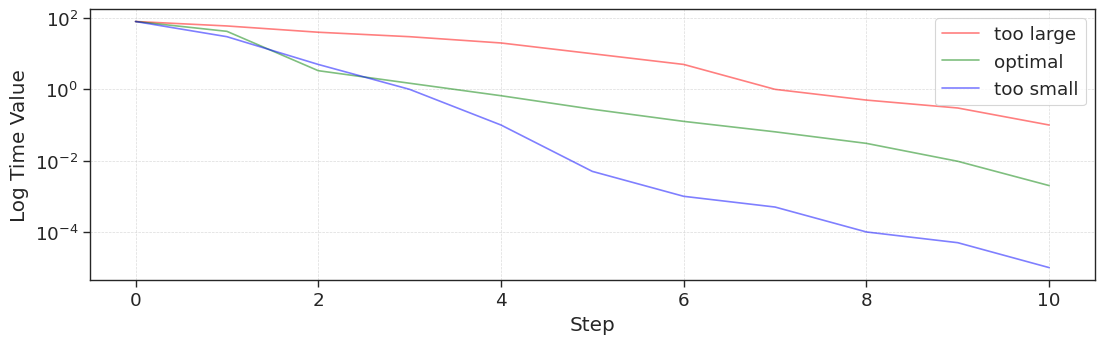

In [31]:
plt.figure(figsize=(12, 4))

plt.plot(timestep_large.flatten().detach().cpu().numpy(), label="too large", alpha=0.5, color='red')
plt.plot(timestep_optimal.flatten().detach().cpu().numpy(), label="optimal", alpha=0.5, color='green')
plt.plot(timestep_small.flatten().detach().cpu().numpy(), label="too small", alpha=0.5, color='blue')


plt.xlabel('Step')
plt.ylabel('Log Time Value')
plt.yscale('log')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join("graphics", "GoodVsBad_Trajectories.jpg"),
    format='jpg',
    dpi=600,
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()






In [ ]:
n3_params = torch.tensor([0.6048, 1.0274, 0.6334, 1.8439], device='cuda:0')
n5_params = torch.tensor([0.8088, 1.1801, 0.9390, 0.7322, 0.7591, 2.0050], device='cuda:0')
n7_params = torch.tensor([1.1434, 1.2401, 0.9985, 0.6071, 0.9339, 0.1873, 0.8551, 1.9311], device='cuda:0')
n10_params = torch.tensor([1.6245, 1.3128, 1.5374, 0.6975, 0.8498, 0.9843, 1.3483, 0.6511, 1.1129, 1.2806, 1.6264], device='cuda:0')


n3_params = F.softmax(n3_params, dim=0)
n5_params = F.softmax(n5_params, dim=0)
n7_params = F.softmax(n7_params, dim=0)
n10_params = F.softmax(n10_params, dim=0)

# Plot all trajectories for different steps in one plot, colored by steps (not loss), and plot average per steps

import matplotlib.pyplot as plt
import numpy as np

n = 1000
steps_list = [3, 5, 6, 7, 10]
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(12, 4))

# Add n_params (best params) for each steps in black
n_params_dict = {
    3: torch.tensor([8.0000e+01, 5.9884e+00, 7.5587e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    5: torch.tensor([8.0000e+01, 1.0621e+01, 2.5949e+00, 8.5124e-01, 2.7130e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    6: torch.tensor([8.0000e+01, 1.2389e+01, 3.4480e+00, 1.2409e+00, 4.1899e-01, 1.6694e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    7: torch.tensor([8.0000e+01, 1.2833e+01, 3.7612e+00, 1.5670e+00, 3.4353e-01, 2.2291e-01, 7.3629e-02, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    10: torch.tensor([8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
                      2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
}

# Plot all "best" (black) lines with a single label "LD3" only for the first one
# label_added = False
# for idx, steps in enumerate(steps_list):
#     if steps in n_params_dict:
#         n_params = n_params_dict[steps]
#         feature_steps_n = np.arange(0, len(n_params))
#         label = "LD3" if not label_added else None
#         plt.plot(feature_steps_n, n_params, color='black', linewidth=0.5, label=label, zorder=10)
#         label_added = True

for steps, color in zip(steps_list, color_list):
    optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
    pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:n]

    all_trajectories = []
    for file_name in pt_files:
        file_path = os.path.join(optim_path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
        if timesteps.ndim == 2:
            for t in timesteps:
                all_trajectories.append(t)
        else:
            all_trajectories.append(timesteps)

    all_trajectories = np.array(all_trajectories).squeeze()
    feature_steps = np.arange(0, all_trajectories.shape[1])

    # Plot all trajectories with low alpha
    for i, traj in enumerate(all_trajectories):
        plt.plot(feature_steps, traj, color=color, alpha=10 / n, linewidth=0.5)

    # # Plot average trajectory in bold
    # avg_traj = np.mean(all_trajectories, axis=0)
    # plt.plot(feature_steps, avg_traj, color=color, linewidth=1, label=f'{steps} steps')

plt.xlabel('Step')
plt.ylabel('Log Time Value')
plt.yscale('log')
# plt.title('Timestep Trajectories for Different Steps (Colored by Steps)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join(img_save_dir, f"Timestep_Trajectories_for_Different_Steps_WithoutExtra_{n}.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)

plt.show()



In [ ]:
N = 10 
# STATIC schedules from edm
vp_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/vp_not_0.pt"
vp_state_dict = torch.load(vp_model_path, map_location=device)
ve_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/ve_not_0.pt"
ve_state_dict = torch.load(ve_model_path, map_location=device)
iddpm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/iddpm_not_0.pt"
iddpm_state_dict = torch.load(iddpm_model_path, map_location=device)
edm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/edm_not_0.pt"
edm_state_dict = torch.load(edm_model_path, map_location=device)

ld3_timesteps = torch.tensor([8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
    2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03], device=device)



plt.figure(figsize=(12, 4))
# plt.plot(timestep_optimal.flatten().detach().cpu().numpy(), label="optimal", alpha=0.5, color='black')
# plt.plot(ld3_timesteps.cpu().numpy(), label="LD3", color='black', linestyle='--', linewidth=2)
plt.plot(np.arange(N+1), vp_state_dict[N].cpu(), label='VP (Linear)')
plt.plot(np.arange(N+1), ve_state_dict[N].cpu(), label='VE (Geometric)')
plt.plot(np.arange(N+1), iddpm_state_dict[N].cpu(), label='IDDPM (Cosine)')
plt.plot(np.arange(N+1), edm_state_dict[N].cpu(), label='EDM (Karras)')
plt.xlabel('Step')
plt.ylabel('Log Timestep Value')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join("graphics", "TimeDiscretization_Schedules.jpg"),
    format='jpg',
    dpi=600,
    bbox_inches='tight',
    pad_inches=0.1
)

print(f"VP: {vp_state_dict[N]}")
print(f"VE: {ve_state_dict[N]}")
print(f"IDDPM: {iddpm_state_dict[N]}")
print(f"EDM: {edm_state_dict[N]}")

In [ ]:
N = 10 
# STATIC schedules from edm
vp_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/vp_0.pt"
vp_state_dict = torch.load(vp_model_path, map_location=device)
ve_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/ve_0.pt"
ve_state_dict = torch.load(ve_model_path, map_location=device)
iddpm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/iddpm_0.pt"
iddpm_state_dict = torch.load(iddpm_model_path, map_location=device)
edm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/edm_0.pt"
edm_state_dict = torch.load(edm_model_path, map_location=device)

ld3_timesteps = torch.tensor([8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
    2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03], device=device)



plt.figure(figsize=(12, 4))
plt.plot(timestep_optimal.flatten().detach().cpu().numpy(), label="optimal", alpha=0.5, color='black')
plt.plot(ld3_timesteps.cpu().numpy(), label="LD3", color='black', linestyle='--', linewidth=2)
plt.plot(np.arange(N+1), vp_state_dict[N].cpu(), label='VP (Linear)')
plt.plot(np.arange(N+1), ve_state_dict[N].cpu(), label='VE (Geometric)')
plt.plot(np.arange(N+1), iddpm_state_dict[N].cpu(), label='IDDPM (Cosine)')
plt.plot(np.arange(N+1), edm_state_dict[N].cpu(), label='EDM (Karras)')
plt.xlabel('Step')
plt.ylabel('Log Timestep Value')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join("graphics", "TimeDiscretization_Schedules.jpg"),
    format='jpg',
    dpi=600,
    bbox_inches='tight',
    pad_inches=0.1
)

print(f"VP: {vp_state_dict[N]}")
print(f"VE: {ve_state_dict[N]}")
print(f"IDDPM: {iddpm_state_dict[N]}")
print(f"EDM: {edm_state_dict[N]}")

### Compare optimal params for different images

In [ ]:
#load from torch.save(loss_matrix, os.path.join(args.data_dir, f"loss_matrix.pt"))
# optimal_dir = os.path.join(data_dir, "OldOptimSteps")


In [ ]:
optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:]

In [ ]:
for i, file_name in enumerate(pt_files): #load all training files previously created
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    data = params.detach().numpy()
    losses = loss.detach().numpy()

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    # Plot the results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                        c=losses, cmap='viridis', edgecolor='k', s=100)
    plt.colorbar(scatter, label='Loss')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Visualization Colored by Loss: {i}')
    plt.grid(True)
    plt.show()
    print("params\n", data)
    print("losses\n", losses)
    if i > 10:
        break

In [ ]:
interesting_processes = list(pt_files[i] for i in [0,1,7,9])

In [ ]:
# Initialize an empty list to store data from all files
all_params = []

# Iterate through all files in pt_files
for file_name in interesting_processes:
    file_path = os.path.join(optim_path, file_name)
    # Load parameters from the file
    params, _ = torch.load(file_path, weights_only=True)
    all_params.append(params.detach().numpy())

# Concatenate all parameters into a single numpy array
all_params = np.vstack(all_params)

# Fit PCA to the concatenated data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_params)

# Print the shape of the principal components
print(f"Principal components shape: {principal_components.shape}")

In [ ]:
# Create subplots with a clean style
from matplotlib.colors import Normalize
from matplotlib import cm

# Plot with global normalization
all_losses = []
for i, file_name in enumerate(interesting_processes[:4]):
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    all_losses.append(loss.detach().cpu().numpy())
all_losses_flat = np.concatenate(all_losses)
norm = Normalize(vmin=np.min(all_losses_flat), vmax=np.max(all_losses_flat))
cmap = cm.get_cmap('viridis')



fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot with global normalization
for i, file_name in enumerate(interesting_processes[:4]):
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    data = params.detach().cpu().numpy()
    losses = loss.detach().cpu().numpy()

    # Apply PCA
    principal_components = pca.transform(data)

    # Use global colormap norm
    scatter = axes[i].scatter(
        principal_components[:, 0],
        principal_components[:, 1],
        c=losses,
        cmap=cmap,
        norm=norm,
        edgecolor='k',  # Add black edges for better visibility
        s=50
    )

    # Highlight the minimum loss point
    min_loss_idx = np.argmin(losses)
    axes[i].scatter(
        principal_components[min_loss_idx, 0],
        principal_components[min_loss_idx, 1],
        color='red',
        marker='x',
        s=100,
        label="Minimal Loss" if i == 1 else None  # Ensure label only appears in figure 2
    )
    if i == 1:  # Add legend only for figure 2
        axes[i].legend(loc="upper right", fontsize=10)


    # Add the real data point above the best point
    if i == 0:  # Move the first list significantly to the right
        principal_components[:, 0] += 0.1
    elif i == 1:  # Move the second list slightly to the right
        principal_components[:, 0] += 0.05
    elif i == 3:  # Move the fourth list slightly to the right
        principal_components[:, 0] += 0.05

    real_data_point = np.round(data[min_loss_idx], 2)
    axes[i].text(
        principal_components[min_loss_idx, 0],
        principal_components[min_loss_idx, 1] + 0.02,  # Offset slightly above the point
        f"{[round(x, 2) for x in real_data_point.tolist()]}",
        color="grey",
        fontsize=8,
        ha="center"
    )

    # Add gridlines
    axes[i].grid(True, linestyle='--', linewidth=0.5)

# Shared axis labels
fig.text(0.5, 0.02, '          Principal Component 1', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Principal Component 2', va='center', rotation='vertical', fontsize=10)

# Add shared colorbar with global normalization
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical', fraction=0.02, pad=0)
pos = cbar.ax.get_position()
cbar.ax.set_position([
    pos.x0 + 0.0787,  # shift right
    pos.y0,
    pos.width,
    pos.height
])
cbar.set_label('Loss', fontsize=12)

# Add a single title for the entire figure
# fig.suptitle('     Local Optima for Time Discretizations for Four Different Diffusion Processes', fontsize=16, y=0.92)

# Adjust layout for tighter spacing
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
# Save the figure as a high-resolution image with additional white padding on the right
plt.savefig(
    os.path.join(img_save_dir, "Local_Optima_for_Time_Discretizations_for_Four_Different_Diffusion_Processes.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.5
)

# Show the plot
plt.show()


In [ ]:
n_vis = 3
pt_files = [f for f in os.listdir(optim_path) if "optimal_params" in f]
pt_files = sorted(pt_files)[:n_vis]  # Load first 6 training files

shapes = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'cross'][:n_vis]  # Different marker shapes

all_data = []
best_losses = []



for i, file_name in enumerate(pt_files):
    file_path = os.path.join(optim_path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses)


all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["Shape"] = [x for x in shapes for _ in range(10)]
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss", symbol="Shape",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show() 

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()


### Visualize Different Timestep Paths

In [ ]:
optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:1]

for i, file_name in enumerate(pt_files): #load all training files previously created
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)

    losses = loss.detach().numpy()
    timesteps = dis_model.convert(params).detach().numpy()
    feature_steps = torch.arange(1, 7)  # x-axis: steps 1 through 6

    plt.figure(figsize=(10, 6))

    for loss, timestep in zip(losses,timesteps):
        plt.plot(feature_steps, timestep, label=f'Timestep {loss}')

    plt.xlabel('Feature Step (1 to 6)')
    plt.ylabel('Value')
    plt.yscale('log')
    plt.title('Feature Trajectories at Each Timestep')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize different timestep trajectories, colored by loss (green=low, red=high)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:500]  # Show more trajectories

all_trajectories = []
all_losses = []

for file_name in pt_files:
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params).detach().cpu().numpy()
    losses = loss.detach().cpu().numpy()
    # If multiple trials, add all; else, add single
    if timesteps.ndim == 2:
        for t, l in zip(timesteps, losses):
            all_trajectories.append(t)
            all_losses.append(l)
    else:
        all_trajectories.append(timesteps)
        all_losses.append(losses)

all_trajectories = np.array(all_trajectories)
all_losses = np.array(all_losses)

# Normalize losses for colormap (green=low, red=high)
norm = (all_losses - all_losses.min()) / (all_losses.max() - all_losses.min() + 1e-8)
colors = cm.get_cmap('RdYlGn_r')(norm)  # 'RdYlGn_r': green=low, red=high

feature_steps = np.arange(1, all_trajectories.shape[1] + 1)

plt.figure(figsize=(10, 6))
for i, (traj, color) in enumerate(zip(all_trajectories, colors)):
    plt.plot(feature_steps, traj, color=color, alpha=0.008, label=f'Loss={all_losses[i]:.4f}' if i < 1 else None)

sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=all_losses.min(), vmax=all_losses.max()))
# Add colorbar to the current figure and axes
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Loss (green=low, red=high)')

plt.xlabel('Feature Step')
plt.ylabel('Timestep Value')
plt.yscale('log')
plt.title('Timestep Trajectories Colored by Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize different timestep trajectories, colored by loss (green=low, red=high)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

optim_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/OldOptimSteps"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:500]  # Show more trajectories

all_trajectories = []
all_losses = []

for file_name in pt_files:
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
    losses = loss[0:1].detach().cpu().numpy()
    # If multiple trials, add all; else, add single
    if timesteps.ndim == 2:
        for t, l in zip(timesteps, losses):
            all_trajectories.append(t)
            all_losses.append(l)
    else:
        all_trajectories.append(timesteps)
        all_losses.append(losses)

all_trajectories = np.array(all_trajectories)
all_losses = np.array(all_losses)

# Normalize losses for colormap (green=low, red=high)
norm = (all_losses - all_losses.min()) / (all_losses.max() - all_losses.min() + 1e-8)
colors = cm.get_cmap('RdYlGn_r')(norm)  # 'RdYlGn_r': green=low, red=high

feature_steps = np.arange(1, all_trajectories.shape[1] + 1)

plt.figure(figsize=(10, 6))
for i, (traj, color) in enumerate(zip(all_trajectories, colors)):
    plt.plot(feature_steps, traj, color=color, alpha=0.08, label=f'Loss={all_losses[i]:.4f}' if i < 1 else None)

sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=all_losses.min(), vmax=all_losses.max()))
# Add colorbar to the current figure and axes
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Loss (green=low, red=high)')

plt.xlabel('Feature Step')
plt.ylabel('Timestep Value')
plt.yscale('log')
plt.title('Timestep Trajectories Colored by Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize different timestep trajectories, colored by loss (green=low, red=high)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

steps_list = [3, 5, 6, 7, 10]
for steps in steps_list:
    optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
    pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:5000]  # Show more trajectories

    all_trajectories = []
    all_losses = []
    for file_name in pt_files:
        file_path = os.path.join(optim_path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
        losses = loss[0:1].detach().cpu().numpy()
        # If multiple trials, add all; else, add single
        if timesteps.ndim == 2:
            for t, l in zip(timesteps, losses):
                all_trajectories.append(t)
                all_losses.append(l)
        else:
            all_trajectories.append(timesteps)
            all_losses.append(losses)

    all_trajectories = np.array(all_trajectories)
    all_losses = np.array(all_losses)

    # Normalize losses for colormap (green=low, red=high)
    norm = (all_losses - all_losses.min()) / (all_losses.max() - all_losses.min() + 1e-8)
    colors = cm.get_cmap('RdYlGn_r')(norm)  # 'RdYlGn_r': green=low, red=high

    feature_steps = np.arange(1, all_trajectories.shape[1] + 1)

    plt.figure(figsize=(10, 6))
    for i, (traj, color) in enumerate(zip(all_trajectories, colors)):
        plt.plot(feature_steps, traj, color=color, alpha=0.002, label=f'Loss={all_losses[i]:.4f}' if i < 1 else None)

    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=all_losses.min(), vmax=all_losses.max()))
    # Add colorbar to the current figure and axes
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Loss (green=low, red=high)')

    plt.xlabel('Feature Step')
    plt.ylabel('Timestep Value')
    plt.yscale('log')
    plt.title(f'{steps} Timestep Trajectories Colored by Loss')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_871936/911271365.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


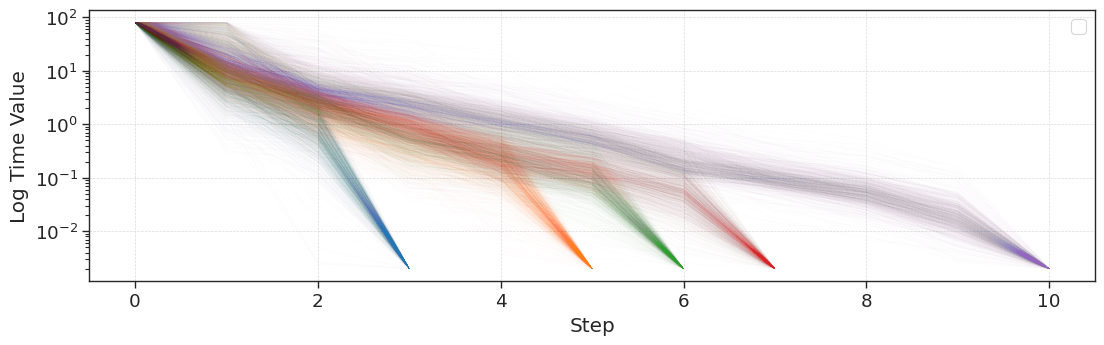

In [21]:
n3_params = torch.tensor([0.6048, 1.0274, 0.6334, 1.8439], device='cuda:0')
n5_params = torch.tensor([0.8088, 1.1801, 0.9390, 0.7322, 0.7591, 2.0050], device='cuda:0')
n7_params = torch.tensor([1.1434, 1.2401, 0.9985, 0.6071, 0.9339, 0.1873, 0.8551, 1.9311], device='cuda:0')
n10_params = torch.tensor([1.6245, 1.3128, 1.5374, 0.6975, 0.8498, 0.9843, 1.3483, 0.6511, 1.1129, 1.2806, 1.6264], device='cuda:0')


n3_params = F.softmax(n3_params, dim=0)
n5_params = F.softmax(n5_params, dim=0)
n7_params = F.softmax(n7_params, dim=0)
n10_params = F.softmax(n10_params, dim=0)

# Plot all trajectories for different steps in one plot, colored by steps (not loss), and plot average per steps

import matplotlib.pyplot as plt
import numpy as np

n = 1000
steps_list = [3, 5, 6, 7, 10]
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(12, 4))

# Add n_params (best params) for each steps in black
n_params_dict = {
    3: torch.tensor([8.0000e+01, 5.9884e+00, 7.5587e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    5: torch.tensor([8.0000e+01, 1.0621e+01, 2.5949e+00, 8.5124e-01, 2.7130e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    6: torch.tensor([8.0000e+01, 1.2389e+01, 3.4480e+00, 1.2409e+00, 4.1899e-01, 1.6694e-01, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    7: torch.tensor([8.0000e+01, 1.2833e+01, 3.7612e+00, 1.5670e+00, 3.4353e-01, 2.2291e-01, 7.3629e-02, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
    10: torch.tensor([8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
                      2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03], device='cuda:0').cpu().numpy().squeeze(),
}

# Plot all "best" (black) lines with a single label "LD3" only for the first one
# label_added = False
# for idx, steps in enumerate(steps_list):
#     if steps in n_params_dict:
#         n_params = n_params_dict[steps]
#         feature_steps_n = np.arange(0, len(n_params))
#         label = "LD3" if not label_added else None
#         plt.plot(feature_steps_n, n_params, color='black', linewidth=0.5, label=label, zorder=10)
#         label_added = True

for steps, color in zip(steps_list, color_list):
    optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
    pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:n]

    all_trajectories = []
    for file_name in pt_files:
        file_path = os.path.join(optim_path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        timesteps = dis_model.convert(params)[0:1].detach().cpu().numpy()
        if timesteps.ndim == 2:
            for t in timesteps:
                all_trajectories.append(t)
        else:
            all_trajectories.append(timesteps)

    all_trajectories = np.array(all_trajectories).squeeze()
    feature_steps = np.arange(0, all_trajectories.shape[1])

    # Plot all trajectories with low alpha
    for i, traj in enumerate(all_trajectories):
        plt.plot(feature_steps, traj, color=color, alpha=10 / n, linewidth=0.5)

    # # Plot average trajectory in bold
    # avg_traj = np.mean(all_trajectories, axis=0)
    # plt.plot(feature_steps, avg_traj, color=color, linewidth=1, label=f'{steps} steps')

plt.xlabel('Step')
plt.ylabel('Log Time Value')
plt.yscale('log')
# plt.title('Timestep Trajectories for Different Steps (Colored by Steps)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig(
    os.path.join(img_save_dir, f"Timestep_Trajectories_for_Different_Steps_WithoutExtra_{n}.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)

plt.show()



### Try to cluster timesteps

In [5]:
n = 50000 #10000
optim_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{steps}"
pt_files = sorted([f for f in os.listdir(optim_path) if "optimal_params" in f])[:n]

all_timesteps = []
all_loses = []
for file_name in pt_files:
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)[0].detach().cpu().numpy()
    losses = loss[0:1].detach().cpu().numpy()

    all_timesteps.append(timesteps)
    all_loses.append(losses)

In [6]:
all_timesteps_np = np.array(all_timesteps).squeeze()
all_loses_np = np.array(all_loses).squeeze()

#filter out all loses and mask params under 95percentile
percentile = np.percentile(all_loses_np, 95)
mask = all_loses_np < percentile
all_timesteps_np = all_timesteps_np[mask]
all_loses_np = all_loses_np[mask]

In [7]:
n_extremes = 5

Indices of 5 largest summed trajectories: [22716 43998  6205 34163 45349]
Indices of 5 smallest summed trajectories: [37975 22958  2952  8636  5052]


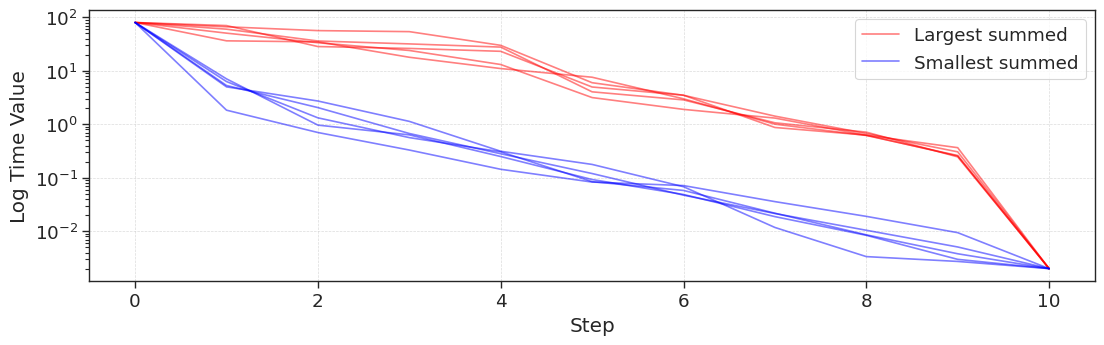

In [8]:
#normalize all timesteps to range [0, 1]
# Normalize all timesteps column-wise to range [0, 1]
all_timesteps_normalized_np = (all_timesteps_np - np.min(all_timesteps_np, axis=0)) / (np.max(all_timesteps_np, axis=0) - np.min(all_timesteps_np, axis=0) + 1e-8)

# Compute the sum of each trajectory
sums = all_timesteps_normalized_np.sum(axis=1)

# Get indices of the 5 largest and 5 smallest summed trajectories
largest_indices = np.argsort(sums)[-n_extremes:][::-1]
smallest_indices = np.argsort(sums)[:n_extremes]

print("Indices of 5 largest summed trajectories:", largest_indices)
print("Indices of 5 smallest summed trajectories:", smallest_indices)

# Plot the 5 largest and 5 smallest summed trajectories
plt.figure(figsize=(12, 4))
# Plot largest summed trajectories (red) with a single label
for i, idx in enumerate(largest_indices):
    label = 'Largest summed' if i == 0 else None
    plt.plot(all_timesteps_np[idx], label=label, alpha=0.5, color='red')

# Plot smallest summed trajectories (blue) with a single label
for i, idx in enumerate(smallest_indices):
    label = 'Smallest summed' if i == 0 else None
    plt.plot(all_timesteps_np[idx], label=label, alpha=0.5, color='blue')
plt.xlabel('Step')
plt.ylabel('Log Time Value')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
# Style: match the style from the reference plot
plt.savefig(
    os.path.join(img_save_dir, "Timestep_TrajectoriesExtremes.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()


In [ ]:
#plot the corresponding images
img_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img"

import os
from PIL import Image
import matplotlib.pyplot as plt

indices = list(largest_indices) + list(smallest_indices)
titles = ['Largest'] * n_extremes + ['Smallest'] * n_extremes

fig, axes = plt.subplots(2, n_extremes, figsize=(15, 6))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

for i, idx in enumerate(indices):
    fname = f"{idx:06d}.png"
    fpath = os.path.join(img_path, fname)
    img = Image.open(fpath)
    ax = axes[i // n_extremes, i % n_extremes]
    ax.imshow(img)
    ax.set_title(f"{titles[i]} {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Plot the corresponding images with "Largest" and "Smallest" on the left,
# no whitespace between images, and black boxes around images
import os
from PIL import Image
import numpy as np
from scipy.stats import entropy
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.filters import sobel
from skimage.feature import canny
import matplotlib.pyplot as plt


def shannon_entropy(img):
    """Calculate the Shannon entropy of the image."""
    if img.mode != 'L':
        img_gray = img.convert('L')
    else:
        img_gray = img
    arr = np.array(img_gray).flatten()
    hist, _ = np.histogram(arr, bins=256, range=(0, 255), density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

def color_entropy(img):
    """Calculate the entropy for each color channel and return the mean."""
    arr = np.array(img)
    entropies = []
    for c in range(arr.shape[2]):
        hist, _ = np.histogram(arr[..., c].flatten(), bins=256, range=(0, 255), density=True)
        hist = hist[hist > 0]
        entropies.append(entropy(hist, base=2))
    return np.mean(entropies)

def canny_edge_complexity(img):
    """Calculate the number of edge pixels using Canny edge detector."""
    arr = np.array(img.convert('L')) / 255.0
    edges = canny(arr)
    return np.sum(edges)

def texture_lbp(img):
    """Calculate the mean LBP value as a simple texture descriptor."""
    arr = np.array(img.convert('L'))
    lbp = local_binary_pattern(arr, P=8, R=1, method='uniform')
    return np.mean(lbp)

img_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated/optimal_n10"

fig, axes = plt.subplots(2, n_extremes, figsize=(2 * n_extremes, 5))
fig.subplots_adjust(wspace=1.5, hspace=0)

# Add "Largest" and "Smallest" labels on the left
axes[0, 0].set_ylabel("Largest", fontsize=14, rotation=0, labelpad=60, va='center')
axes[1, 0].set_ylabel("Smallest", fontsize=14, rotation=0, labelpad=60, va='center')

indices = list(largest_indices) + list(smallest_indices)

for i, idx in enumerate(indices):
    fname = f"{idx}.png"
    fpath = os.path.join(img_path, fname)
    img = Image.open(fpath)
    row = i // n_extremes
    col = i % n_extremes
    ax = axes[row, col]
    ax.imshow(img)
    ax.axis('on')
    # Draw black box around image
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Calculate metrics
    shannon_ent = shannon_entropy(img)
    color_ent = color_entropy(img)
    canny_complex = canny_edge_complexity(img)
    lbp_texture = texture_lbp(img)

    # Write metrics below the image
    additional_line = ""
    if i < n_extremes:
        additional_line = "\n\n"
    else:
        additional_line = ""
    ax.text(
        0.5, -0.05,
        f"Shannon: {shannon_ent:.2f}\n"
        f"Color: {color_ent:.2f}\n"
        f"Canny: {canny_complex:.0f}\n"
        f"LBP: {lbp_texture:.2f}{additional_line}",
        transform=ax.transAxes,
        fontsize=8,
        ha='center',
        va='top'
    )

plt.tight_layout(pad=0)
plt.savefig(
    os.path.join(img_save_dir, "Images_TrajectoriesExtremes.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()


In [ ]:
from tqdm import tqdm

# Calculate metrics for the largest and smallest 1000 images


# Use the indices of the largest and smallest summed trajectories
n_largest = 1000
n_smallest = 1000

largest_indices_1000 = np.argsort(sums)[-n_largest:][::-1]
smallest_indices_1000 = np.argsort(sums)[:n_smallest]

img_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated/optimal_n10"

def compute_metrics_for_indices(indices):
    shannon_list = []
    color_list = []
    canny_list = []
    lbp_list = []
    for idx in tqdm(indices, desc="Processing images"):
        fname = f"{idx}.png"
        fpath = os.path.join(img_path, fname)
        if not os.path.exists(fpath):
            continue
        img = Image.open(fpath)
        shannon_list.append(shannon_entropy(img))
        color_list.append(color_entropy(img))
        canny_list.append(canny_edge_complexity(img))
        lbp_list.append(texture_lbp(img))
    return {
        "shannon": np.array(shannon_list),
        "color": np.array(color_list),
        "canny": np.array(canny_list),
        "lbp": np.array(lbp_list),
    }

largest_1000_metrics = compute_metrics_for_indices(largest_indices_1000)
smallest_1000_metrics = compute_metrics_for_indices(smallest_indices_1000)

print("Largest 1000 metrics (mean):")
for k, v in largest_1000_metrics.items():
    print(f"  {k}: {np.mean(v):.4f}")

print("Smallest 1000 metrics (mean):")
for k, v in smallest_1000_metrics.items():
    print(f"  {k}: {np.mean(v):.4f}")

#### Calculate Mean, Mean of Best, Std internal, coefficient of variation internal mean, coefficient of variation global
 

In [ ]:
import numpy as np
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]

opt_t_clever_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_clever_initialisation"
opt_t_clever_files = [f for f in os.listdir(opt_t_clever_dir) if f.endswith('.pth')]


In [ ]:


for name, files, path in zip(["opt_t", "opt_t_clever", "100_10"], [opt_t_files, opt_t_clever_files, pt_files], [opt_t_dir, opt_t_clever_dir, optim_path]):
    all_losses = []
    best_losses = []
    std_deviations = []
    coefficients_of_variation = []


    for i, file_name in enumerate(files):
        file_path = os.path.join(path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        all_losses.append(loss.detach().cpu().numpy())
        best_losses.append(loss.detach().cpu().numpy()[0])
        std_deviations.append(np.std(loss.detach().cpu().numpy()))
        coefficients_of_variation.append(std_deviations[-1] / np.mean(loss.detach().cpu().numpy()))
    all_losses_flat = np.concatenate(all_losses)


    mean_loss = np.mean(all_losses_flat)
    std_loss = np.std(all_losses_flat)
    mean_best_loss = np.mean(best_losses)
    std_best_loss = np.std(best_losses)
    mean_std_deviation = np.mean(std_deviations)
    std_std_deviation = np.std(std_deviations)
    mean_coefficient_of_variation = np.mean(coefficients_of_variation)
    std_coefficient_of_variation = np.std(coefficients_of_variation)


    print(f"Results for {name}:")
    print(f"Mean loss: {mean_loss:.4f}")
    print(f"Std loss: {std_loss:.4f}")
    print(f"Mean of best losses: {mean_best_loss:.4f}")
    print(f"Std of best losses: {std_best_loss:.4f}")
    print(f"Internal std deviations: {mean_std_deviation:.4f}")
    # print(f"Std of std deviations: {std_std_deviation:.4f}")
    # print(f"Mean coefficient of variation: {mean_coefficient_of_variation:.4f}")
    # print(f"Std coefficient of variation: {std_coefficient_of_variation:.4f}")


#### all 100x1 runs

In [ ]:
for name, files, path in ["opt_t_final_3", "opt_t_final_5", "opt_t_final_7", "opt_t_final_10"]:
    all_losses = []
    best_losses = []
    std_deviations = []
    coefficients_of_variation = []


    for i, file_name in enumerate(files):
        file_path = os.path.join(path, file_name)
        params, loss = torch.load(file_path, weights_only=True)
        all_losses.append(loss.detach().cpu().numpy())
        best_losses.append(loss.detach().cpu().numpy()[0])
        std_deviations.append(np.std(loss.detach().cpu().numpy()))
        coefficients_of_variation.append(std_deviations[-1] / np.mean(loss.detach().cpu().numpy()))
    all_losses_flat = np.concatenate(all_losses)


    mean_loss = np.mean(all_losses_flat)
    std_loss = np.std(all_losses_flat)
    mean_best_loss = np.mean(best_losses)
    std_best_loss = np.std(best_losses)
    mean_std_deviation = np.mean(std_deviations)
    std_std_deviation = np.std(std_deviations)
    mean_coefficient_of_variation = np.mean(coefficients_of_variation)
    std_coefficient_of_variation = np.std(coefficients_of_variation)


    print(f"Results for {name}:")
    print(f"Mean loss: {mean_loss:.4f}")
    print(f"Std loss: {std_loss:.4f}")
    print(f"Mean of best losses: {mean_best_loss:.4f}")
    print(f"Std of best losses: {std_best_loss:.4f}")
    print(f"Internal std deviations: {mean_std_deviation:.4f}")
    # print(f"Std of std deviations: {std_std_deviation:.4f}")
    # print(f"Mean coefficient of variation: {mean_coefficient_of_variation:.4f}")
    # print(f"Std coefficient of variation: {std_coefficient_of_variation:.4f}")

##### Timestep Distribution

In [ ]:
all_timesteps = []
for file in pt_files:
    file_path = os.path.join(optim_path, file)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)
    all_timesteps.append(timesteps.detach().numpy())
all_timesteps = np.stack(all_timesteps)
all_timesteps = all_timesteps.reshape(-1, steps+1)

# Remove the top 1% of outliers
percentile_99 = np.percentile(all_timesteps, 99, axis=0)
filtered_timesteps = all_timesteps[np.all(all_timesteps <= percentile_99, axis=1)]

# Plot histogram for each column in filtered_timesteps
num_columns = filtered_timesteps.shape[1]
plt.figure(figsize=(15, 10))

for i in range(num_columns):
    plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in rows
    plt.hist(filtered_timesteps[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Timestep {i}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
all_timesteps = []
for file in opt_t_clever_files:
    file_path = os.path.join(opt_t_clever_dir, file)
    params, loss = torch.load(file_path, weights_only=True)
    timesteps = dis_model.convert(params)
    all_timesteps.append(timesteps.detach().numpy())
all_timesteps = np.stack(all_timesteps)
all_timesteps = all_timesteps.reshape(-1, steps+1)

# Remove the top 1% of outliers
percentile_99 = np.percentile(all_timesteps, 99, axis=0)
filtered_timesteps = all_timesteps[np.all(all_timesteps <= percentile_99, axis=1)]

# Plot histogram for each column in filtered_timesteps
num_columns = filtered_timesteps.shape[1]


In [ ]:
timesteps_n5 = dis_model.convert(n5_params.unsqueeze(0))
timesteps_n5

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(num_columns):
    plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in 2 rows
    bins = np.histogram_bin_edges(filtered_timesteps[:, i], bins=30)  # Get bin edges
    hist, bin_edges = np.histogram(filtered_timesteps[:, i], bins=bins, density=True)  # Compute histogram

    # Plot bars with default color
    for j in range(len(hist)):
        color = 'red' if bin_edges[j] <= timesteps_n5[0, i].item() < bin_edges[j + 1] else 'blue'
        plt.bar(
            (bin_edges[j] + bin_edges[j + 1]) / 2,  # Center of the bin
            hist[j],
            width=(bin_edges[j + 1] - bin_edges[j]),  # Bin width
            color=color,
            edgecolor='black',
            alpha=0.7
        )

    plt.title(f"Timestep {5 - i}", fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)  # Updated label since it's normalized

plt.tight_layout()

plt.savefig(
    os.path.join(img_save_dir, "OptimalTimestepsCleverTimestepDistribution.jpg"),
    format='jpg',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.5
)

plt.show()

#### Generate Latex Tabel for losses

In [ ]:
from tabulate import tabulate

# Prepare the data for the table
table_data = []
for i, file_name in enumerate(interesting_processes[:4]):
    file_path = os.path.join(optim_path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    params = params.detach().numpy()
    losses = loss.detach().numpy()

    for j in range(len(losses)):
        # Format the Params column to display floating-point numbers with 2 decimal places
        formatted_params = [f"{x:.2f}" for x in params[j]]
        table_data.append([i, formatted_params, f"{losses[j]:.4f}"])
    # Add a separator row after each file's entries
    table_data.append(["\\hline", "", ""])

# Define the headers for the table
headers = ["Diffusion Process", "Time Discretization", "Loss"]

# Generate the LaTeX table
latex_table = tabulate(table_data, headers=headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)


#### Only best trial

In [ ]:
pt_files = [f for f in os.listdir(optimal_dir) if "optimal_params" in f]
pt_files = sorted(pt_files) # Load first 6 training files

all_data = []
best_losses = []
all_losses = []

for i, file_name in enumerate(pt_files):
    file_path = os.path.join(optimal_dir, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()[0]
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses[0])
    all_losses.append(losses)






all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show()

In [ ]:
#plot loss distribution of all_losses

plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()



In [ ]:
import plotly.graph_objects as go

# Assuming all_losses and best_losses are defined
all_losses = np.stack(all_losses).reshape(-1)

fig = go.Figure()

# Add histogram for all_losses
fig.add_trace(go.Histogram(x=all_losses, nbinsx=75, histnorm='probability density', 
                           name="All Losses", marker_color='blue', opacity=0.5))

# Add histogram for best_losses
fig.add_trace(go.Histogram(x=best_losses, nbinsx=75, histnorm='probability density', 
                           name="Best Losses", marker_color='red', opacity=0.5))

# Update layout
fig.update_layout(
    title="Loss Distribution",
    xaxis_title="Loss",
    yaxis_title="Density",
    barmode='overlay',  # Overlay both histograms
    template="plotly_white"  # Optional: use a clean background
)

fig.show()
print(f"Mean lost of first 50 validation losses: {np.mean(all_losses[:500]):.4f}")
print(f"Mean lost of 50 validation best losses: {np.mean(best_losses[:50]):.4f}")

### New generated ones

In [ ]:
torch.load("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/optimal_params_000003_N10_steps5.pth")

#### With 30 iterations and only 1 trial

In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1]
    loss_np[i] = opt_t


print(f"Mean loss of optimal train timesteps: {np.mean(loss_np):.4f}")



In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation/opt_t"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1]
    loss_np[i] = opt_t


print(f"Mean loss of optimal validation timesteps: {np.mean(loss_np):.4f}")

#### With 50 iterations and 3 trials

In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_clever_initialisation"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1][0]
    loss_np[i] = opt_t


print(f"Mean loss of optimal train timesteps: {np.mean(loss_np):.4f}")



In [ ]:
opt_t_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation/opt_t_clever_initialisation"
opt_t_files = [f for f in os.listdir(opt_t_dir) if f.endswith('.pth')]
opt_t_files = sorted(opt_t_files) 


loss_np = np.zeros((len(opt_t_files)))

for i,file_path in enumerate(opt_t_files):
    opt_t_path = os.path.join(opt_t_dir, file_path)
    opt_t = torch.load(opt_t_path, weights_only=True)[1][0]
    loss_np[i] = opt_t


print(f"Mean loss of optimal validation timesteps: {np.mean(loss_np):.4f}")

## Generating latent -> image pairs efficiently in mass

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np

# Load the PNG image
image_path = '/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img/000000.png'
image = Image.open(image_path).convert("RGB")

# Define a transform to convert the image to a tensor
transform_to_tensor = transforms.ToTensor()

# Apply the transform to the image
tensor_from_img = transform_to_tensor(image)

# Verify the tensor shape and type
print(f"Tensor shape: {tensor_from_img.shape}")  # Should print: torch.Size([C, H, W])
print(f"Tensor dtype: {tensor_from_img.dtype}")  # Should print: torch.float32



In [ ]:
def png_to_tensor(image):
    # Load image

    # Convert to NumPy array and normalize (0-255 → 0-1)
    image_np = np.array(image, dtype=np.float32) / 255.0

    # Reorder dimensions (H, W, C) → (C, H, W)
    image_tensor = torch.tensor(image_np).permute(2, 0, 1)

    # Reverse normalization ((x * 2) - 1)
    image_tensor = (image_tensor * 2.0) - 1.0  

    return image_tensor

In [ ]:
tensor_original = torch.load("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/test_images/img_000000.pt")
print(f"Tensor shape: {tensor_original.shape}")  # Should print: torch.Size([C, H, W])
print(f"Tensor dtype: {tensor_original.dtype}")  # Should print: torch.float32


to_pil = transforms.ToPILImage()
image_pil = to_pil((tensor_original +1 ) / 2)
# image_pil = to_pil(torch.clip((tensor_original +1 ) / 2, 0,1))
plt.imshow(image_pil)


In [ ]:
img_tensor = transform_to_tensor(image_pil)
img_tensor = (img_tensor - 0.5) * 2



In [ ]:
torch.sum(img_tensor - tensor_original)

In [ ]:
from PIL import Image
import numpy as np

# Convert the tensor to a numpy array and transpose the dimensions to match the image format
tensor_original_np = tensor_original.permute(1, 2, 0).numpy()

# Convert the tensor values from the range [-1, 1] to [0, 255]
tensor_original_np = ((tensor_original_np + 1) * 127.5).astype(np.uint8)

# Create a PIL image from the numpy array
image_pil = Image.fromarray(tensor_original_np)

# Save the image
image_pil.save("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/test_images/image.png")

In [ ]:
torch.sum(png_to_tensor(image) - torch.clip(tensor_original, -1,1))

In [ ]:
image = np.transpose(tensor_original, (1, 2, 0))
convert =  lambda x: (x + 1.0) / 2.0
image = convert(image)


# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.savefig("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/test_images/original_image.png")
plt.show()

In [ ]:

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Create a random tensor [3, 32, 32] with values in range [-1, 1]
original_tensor = torch.rand(3, 32, 32) * 2 - 1  # Scale to [-1, 1]

# Convert tensor to image
def tensor_to_image(tensor):
    tensor = (tensor + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)  # Ensure valid range
    image_np = (tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    return Image.fromarray(image_np, "RGB")

# Convert image back to tensor
def image_to_tensor(image):
    image_np = np.array(image).astype(np.float32) / 255.0  # Convert to [0,1]
    tensor = torch.tensor(image_np).permute(2, 0, 1)  # Convert to [C, H, W]
    tensor = (tensor * 2.0) - 1.0  # Scale back to [-1, 1]
    return tensor

# Convert tensor to image and display it
image = tensor_to_image(original_tensor)
plt.imshow(image)
plt.axis("off")
plt.show()

# Convert image back to tensor
recovered_tensor = image_to_tensor(image)

# Calculate difference
difference = torch.abs(original_tensor - recovered_tensor)
error = torch.mean(difference).item()  # Mean absolute error

print(f"Mean Absolute Error between original and recovered tensor: {error}")


In [ ]:
def visualize(tensor: torch.Tensor) -> None:
    convert =  lambda x: (x + 1.0) / 2.0
    samples_raw = convert(tensor.unsqueeze(0))
    samples = np.clip(  #10 because of batch size
                    samples_raw.permute(0, 2, 3, 1).cpu().numpy() * 255.0, 0, 255
                ).astype(np.uint8)
    image_np = samples.reshape((-1, 32, 32, 3))[0]



    plt.imshow(image_np)
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()

# PIL.Image.fromarray(image_np, "RGB").save(image_path)

In [ ]:
tensor_original_np = tensor_original.detach().cpu().numpy()
tensor_from_img_np = tensor_from_img.detach().cpu().numpy()
undo_convert = lambda x: (x * 2.0) - 1.0
tensor_from_img_np = undo_convert(tensor_from_img_np)
tensor_original_np = np.clip(tensor_original_np, 0, 1)
tensor_from_img_np = np.clip(tensor_from_img_np, 0, 1)
np.sum(tensor_original_np - tensor_from_img_np)


In [ ]:
# Plot the original tensor image and the tensor from the loaded image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Convert tensors to numpy arrays for plotting
tensor_original_np = tensor_original.permute(1, 2, 0).numpy()
tensor_from_img_np = tensor_from_img.permute(1, 2, 0).numpy()
undo_convert = lambda x: (x * 2.0) - 1.0
tensor_from_img_np = undo_convert(tensor_from_img_np)

# Plot the original tensor image
axes[0].imshow(tensor_original_np)
axes[0].set_title('Original Tensor Image')
axes[0].axis('off')

# Plot the tensor from the loaded image
axes[1].imshow(tensor_from_img_np)
axes[1].set_title('Tensor from Loaded Image')
axes[1].axis('off')

plt.show()

In [ ]:
visualize(tensor_original)

In [ ]:
from dataset import LTTDataset
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation"
dataset = LTTDataset(path)

for i in range(1):
    img, latent, opt_t = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    print(opt_t)

    plt.show()

# the second output should be exactly the same proving that the data generator working
for i in range(1):
    img, latent, _ = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()


In [ ]:
from dataset import LTTDataset
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img"
dataset = LTTDataset(path)

for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()

# the second output should be exactly the same proving that the data generator working correctly
for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()


## Delta Timestep Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Add this import
import lpips
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import get_solvers, move_tensor_to_device, parse_arguments, set_seed_everything

from dataset import load_data_from_dir, LTTDataset
from latent_to_timestep_model import  Delta_LTT_model
from models import prepare_stuff
import torch.optim.lr_scheduler as lr_scheduler
from utils import visual


args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

In [ ]:
# Load the saved state dictionary

group_norm_model = "model_lr5e-05_batch3_nTrain500000_BiggerValidation_GroupNorm_EvalTrue"
rerun_alpha_3 = "model_lr5e-05_batch3_nTrain500000_RerunAlpha"
rerun_alpha_30 = "model_lr5e-05_batch30_nTrain500000_RerunAlpha"
state_dict = torch.load(os.path.join(model_dir, rerun_alpha_30), map_location=device,weights_only=True)

# Load the state dictionary into the delta_ltt_model
delta_ltt_model.load_state_dict(state_dict)

print("Parameters successfully loaded into delta_ltt_model.")

### Training Data


In [ ]:
with torch.no_grad():
    delta_ltt_model.eval()
    for i,batch in enumerate(trainer.train_loader):
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)

        x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
        x_next_computed = []
        x_next_list_computed = []
        for x in x_next_list:
            x_next, x_list, _ = trainer.solver.delta_sample_simple(
                model_fn=trainer.net,
                delta_ltt=delta_ltt_model,
                x=x.unsqueeze(0),
                order=trainer.order,
                steps = trainer.steps,
                start_timestep = 80,
                NFEs=trainer.steps,
                condition=None,
                unconditional_condition=None,
                **trainer.solver_extra_params,
            )
            x_next_computed.append(x_next)
        
        x_next_computed = torch.cat(x_next_computed, dim=0) 
        loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
        loss = loss_vector.mean()
        print(f"Validated on iter{i}: {loss.item()}")

In [ ]:
x_next_list.shape

In [ ]:
x.shape

### Valdiation Data

In [ ]:

all_timesteps = np.zeros((args.num_valid, steps+1))
all_losses = np.zeros((args.num_valid) // args.main_valid_batch_size)

with torch.no_grad():
    delta_ltt_model.eval()
    for i,batch in enumerate(trainer.valid_only_loader):
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)

        x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
        x_next_computed = []
        x_next_list_computed = []
        for j, x in enumerate(x_next_list):
            x_next, x_list, t_list = trainer.solver.delta_sample_simple(
                model_fn=trainer.net,
                delta_ltt=delta_ltt_model,
                x=x.unsqueeze(0),
                order=trainer.order,
                steps = trainer.steps,
                start_timestep = 80,
                NFEs=trainer.steps,
                condition=None,
                unconditional_condition=None,
                **trainer.solver_extra_params,
            )
            x_next_computed.append(x_next)#This was wrong the whole time?
            all_timesteps[i*args.main_valid_batch_size+j] = t_list
        
        x_next_computed = torch.cat(x_next_computed, dim=0) 
        loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
        loss = loss_vector.mean()
        all_losses[i] = loss.item()
        print(f"Validated on iter{i}: {loss.item()}")

In [ ]:
print(f"Average Loss: {np.mean(all_losses)}")

#### Validation at different n_steps

In [ ]:

n_steps_list = [3, 5, 6, 7, 10]
model_path_list = [
    "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalDelta",   
    "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalDelta"
]

for n_steps, path in zip(n_steps_list, model_path_list):
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Running Test set for {n_steps} steps")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
        

### Timestep Distribution

In [ ]:
# Plot histogram for each column in all_timesteps
num_columns = all_timesteps.shape[1]
plt.figure(figsize=(15, 10))

for i in range(num_columns):
    plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in rows
    plt.hist(all_timesteps[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Timestep {i}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Influence if Prior Timestep and Steps Left

In [ ]:
all_ratios = np.zeros((80))
for t in range(0,80):
    delta_timestep_ratio = delta_ltt_model(latent.unsqueeze(0), torch.tensor(t, device=device), torch.tensor(5, device=device))
    all_ratios[t] = delta_timestep_ratio.item()


In [ ]:
plt.scatter(range(len(all_ratios)), all_ratios, color='blue', alpha=0.7)
plt.title("All Ratios at differnt timestep with same latent")
plt.xlabel("Index")
plt.ylabel("Ratio")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Runtime of Diffusion Model vs DLTT 

In [ ]:
latent = valid_dataset[0][1].to(device)

In [ ]:
import pickle
from noise_schedulers import NoiseScheduleVE
from models.edm_uncond import model_wrapper
with open("pretrained/edm-cifar10-32x32-uncond-vp.pkl", "rb") as f:
    net = pickle.load(f)["ema"].to(device)
noise_schedule = NoiseScheduleVE(schedule='edm')

for param in net.parameters():
    param.requires_grad = False

model_fn = model_wrapper(net, noise_schedule, False)

x = latent.unsqueeze(0)
t = torch.tensor(80, device = device)
model_fn(x, t.expand((x.shape[0])))

In [ ]:
net(x, t.expand((x.shape[0])))

In [ ]:
#stack 10000 latens and run them through while measuring time
import time

all_latents = torch.stack([latent for _ in range(1000)])
all_latents = all_latents.to(device)
t = torch.tensor(80, device = device)
start = time.time()
model_fn(all_latents, t.expand((all_latents.shape[0])))
end = time.time()
print(f"Time taken for 1000 latents: {end-start}")


In [ ]:
t = torch.tensor(80, device = device)
start = time.time()
for i in range(100):
    delta_ltt_model(all_latents, t, torch.tensor(5, device=x.device))
end = time.time()
print(f"Time taken for 1000 latents: {(end-start) / 100}")

In [ ]:
4.404688119888306 / 0.05439952373504639

#### Attempting to get Bottleneck layer

In [ ]:
torch.cuda.empty_cache()
from torchsummary import summary

In [ ]:
# Create a custom wrapper to handle the additional argument
class ModelSummaryWrapper(nn.Module):
    def __init__(self, model, device):
        super(ModelSummaryWrapper, self).__init__()
        self.model = model.to(device)
        self.device = device

    def forward(self, x):
        x = x.to(self.device)
        batch_size = x.shape[0]
        t = torch.tensor(80, device=self.device).expand(batch_size)
        return self.model(x, t)

# Wrap the model and ensure everything is on the same device
summary_wrapper = ModelSummaryWrapper(net, device)

# Create a dummy input tensor on the correct device
dummy_input = torch.randn(1, 3, 32, 32, device=device)

# Print the summary of the model
summary(summary_wrapper, input_size=(3, 32, 32), device="cuda")

In [ ]:
for i, (name, layer) in enumerate(net.named_modules()):
    print(f"{i+1}: Layer Name: {name}, Layer Type: {type(layer)}")

In [ ]:
net.model

In [ ]:
list(net.named_modules())

In [ ]:
model = net.model

def hook_fn(module, input, output):
    global bottleneck_output
    bottleneck_output = output

# Register the hook
hook = model.enc["8x8_block3"].conv1.register_forward_hook(hook_fn)

input_image = torch.randn(1, 3, 32, 32)
output_image = model(x, t.expand((x.shape[0])), None)
print(bottleneck_output.shape)

hook.remove()
bottleneck_output
#model.enc

#### Visualize Delta Ltt

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the SummaryWriter
writer = SummaryWriter(log_dir="runs/delta_ltt_model_visualization")

# Add the model graph to TensorBoard
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Adjust dimensions as needed
writer.add_graph(delta_ltt_model, (dummy_input, torch.tensor(80, device=device), torch.tensor(5, device=device)))

# Close the writer
writer.close()

print("Model graph has been added to TensorBoard. Run the following command to view it:")
print("tensorboard --logdir=runs/model_visualization")

## Compare all Results

In [1]:
import pandas as pd
import io

data = """
Method,LPIPS_3,LPIPS_5,LPIPS_6,LPIPS_7,LPIPS_10,FID_3,FID_5,FID_6,FID_7,FID_10
VP Schedule,0.286,0.167,0.142,0.121,0.089,61.783,25.372,19.421,16.404,12.344
VE Schedule,0.387,0.236,0.178,0.135,0.062,155.934,22.645,12.240,6.358,3.156
iDDPM Schedule,0.338,0.322,0.324,0.316,0.286,59.442,32.149,32.906,32.704,29.453
EDM Schedule,0.320,0.282,0.218,0.185,0.102,58.486,31.667,17.278,11.642,5.979
LD3,0.279,0.145,0.113,0.083,0.032,56.617,16.536,10.619,6.228,3.013
Global,0.275,0.145,0.112,0.082,0.028,51.120,15.712,10.338,5.778,3.069
Global Variable Last Ts.,0.271,0.130,0.095,0.071,0.019,61.274,30.063,19.132,13.414,2.790
Zero-Shot,0.273,0.145,0.113,0.082,0.021,50.087,16.256,10.243,5.598,2.939
Zero-Shot on Optimal Ts.,0.277,0.159,0.124,0.084,0.032,52.236,13.809,9.340,5.713,2.843
Delta Variable Last Ts.,0.263,0.117,0.085,0.059,0.017,61.883,28.451,22.431,18.785,6.929
Delta Fixed Last Ts.,0.270,0.140,0.110,0.080,0.029,50.652,17.989,12.416,7.590,4.901
Delta on Optimal Ts.,0.274,0.152,0.114,0.089,0.029,48.860,13.048,8.456,5.305,2.770
Delta Just Image,0.270,0.140,0.110,0.080,0.020,50.774,17.922,12.569,7.576,5.005
Delta Huge,0.272,0.140,0.109,0.083,0.028,51.419,15.513,9.946,6.480,3.462
Delta Fancy,0.272,0.141,0.111,0.083,0.020,49.549,16.370,10.572,5.506,2.927
Delta Bottleneck,0.276,0.146,0.114,0.082,0.021,48.960,17.310,10.316,5.892,2.932
Delta Huge Bottleneck,0.269,0.136,0.104,0.077,0.026,48.977,16.120,9.691,7.009,3.024
Optimal Ts.,0.225,0.087,0.054,0.033,0.008,38.785,9.695,5.603,3.937,2.506
"""

df = pd.read_csv(io.StringIO(data))
df = df.set_index("Method")

In [2]:
df.loc["LD3*"] = pd.DataFrame([df.loc["LD3"], df.loc["Global"]]).min(axis=0)
df.drop(["Global", "LD3"], inplace=True)
df

,LPIPS_3,LPIPS_5,LPIPS_6,LPIPS_7,LPIPS_10,FID_3,FID_5,FID_6,FID_7,FID_10
Method,,,,,,,,,,
VP Schedule,0.286,0.167,0.142,0.121,0.089,61.783,25.372,19.421,16.404,12.344
VE Schedule,0.387,0.236,0.178,0.135,0.062,155.934,22.645,12.240,6.358,3.156
iDDPM Schedule,0.338,0.322,0.324,0.316,0.286,59.442,32.149,32.906,32.704,29.453
EDM Schedule,0.320,0.282,0.218,0.185,0.102,58.486,31.667,17.278,11.642,5.979
Global Variable Last Ts.,0.271,0.130,0.095,0.071,0.019,61.274,30.063,19.132,13.414,2.790
Zero-Shot,0.273,0.145,0.113,0.082,0.021,50.087,16.256,10.243,5.598,2.939
Zero-Shot on Optimal Ts.,0.277,0.159,0.124,0.084,0.032,52.236,13.809,9.340,5.713,2.843
Delta Variable Last Ts.,0.263,0.117,0.085,0.059,0.017,61.883,28.451,22.431,18.785,6.929
Delta Fixed Last Ts.,0.270,0.140,0.110,0.080,0.029,50.652,17.989,12.416,7.590,4.901


In [42]:
all_results = df
all_results.to_pickle("all_results.pkl")


In [ ]:
from scipy.stats import pearsonr
lpips_cols = ["LPIPS_3","LPIPS_5","LPIPS_6","LPIPS_7","LPIPS_10"]
fid_cols = ["FID_3", "FID_5", "FID_6", "FID_7", "FID_10"]

# Gather all LPIPS and FID values from the dataframe (excluding summary columns)
lpips_values = df[lpips_cols].values.flatten()
fid_values = df[fid_cols].values.flatten()

# Calculate Pearson correlation
corr, p_value = pearsonr(lpips_values, fid_values)
print(f"Pearson correlation between all LPIPS and FID values: {corr:.4f} (p-value: {p_value:.4e})")

In [ ]:
# Calculate percentage change for all columns compared to LD3 / Global baseline
baseline = df.loc["LD3 / Global"]

for row in df.index:
    if row != "LD3 / Global":
        df.loc[row] = ((df.loc[row] - baseline) / baseline) * 100

# Drop the LD3 / Global row
df = df.drop("LD3 / Global")

# Calculate mean LPIPS % change and mean FID % change for each row
lpips_cols = ['LPIPS_3', 'LPIPS_5', 'LPIPS_6', 'LPIPS_7', 'LPIPS_10']
fid_cols = ['FID_3', 'FID_5', 'FID_6', 'FID_7', 'FID_10']

df["Mean LPIPS % Δ"] = df[lpips_cols].mean(axis=1)
df["Mean FID % Δ"] = df[fid_cols].mean(axis=1)


import matplotlib.pyplot as plt

# Sort the DataFrame by "Mean FID % Δ" in descending order
df_sorted = df.sort_values("Mean FID % Δ", ascending=False)

# Define a color map for the values (red for high, green for low, yellow for mid)
def color_map(val):
    if pd.isnull(val):
        return ''
    if val > 50:
        return 'background-color: #ffcccc'  # light red
    elif val < 0:
        return 'background-color: #ccffcc'  # light green
    else:
        return 'background-color: #ffffcc'  # light yellow

# Apply the color map to all columns except the index
styled = df_sorted.style.applymap(color_map, subset=df_sorted.columns)

# Display the styled DataFrame
styled

In [ ]:
print(df_sorted.to_latex(float_format = "%.3f", escape = True))

### Variability in Resulting Timesteps (Maybe Bottleck)

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import lpips
import plotly.express as px
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import save_image
import pandas as pd



from dataset import LTTDataset, load_data_from_dir
from latent_to_timestep_model import Delta_LTT_model, LTT_model, Tiny_Delta_LTT_model, Medium_Delta_LTT_model, Large_Delta_LTT_model, Huge_Delta_LTT_model, Huge_Delta_LTT_CNN_Bigger, Huge_Delta_LTT_MLP_Bigger, Ginormous_Delta_LTT, Fancy_Delta_LTT_Model, Huge_Bottleneck_Delta, Delta_LTT_model_using_Bottleneck

from models import prepare_stuff
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import (
    adjust_hyper,
    get_solvers,
    move_tensor_to_device,
    parse_arguments,
    set_seed_everything,
    visual
)

In [2]:
set_seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "10000", #45000
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue",
    # f"--use_optimal_params", "True" if use_optimal_params else "False",
    # "--return_bottleneck", "True" if return_bottleneck else "False",
    # "--delta_model_size", delta_model_size,
])
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args,)#return_bottleneck=return_bottleneck
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=10,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)
valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False, optimal_params_path="opt_t_clever_initialisation") 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False, optimal_params_path="opt_t_clever_initialisation")

training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)

model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)

dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [5]:
def evaluate_ld3(n_steps: int):

    path = f"runs_global_timesteps/models/model_N{n_steps}_lr0.001_batch3_nTrain50000_FinalGlobal"
    timestep = torch.load(path, map_location=device)["timesteps"]

    timesteps_list = []
    start_time = time.time()
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
                continue
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            for x in latent:
                x_next = trainer.noise_schedule.prior_transformation(x)
                x_next = trainer.solver.sample_simple(
                    model_fn=trainer.net,
                    x=x_next.unsqueeze(0),
                    timesteps=timestep[0],
                    order=trainer.order,
                    NFEs=n_steps,
                    **trainer.solver_extra_params,
                )

                timesteps_list.append(timestep[0])
    end_time = time.time()
    return torch.stack(timesteps_list, dim = 0).cpu().numpy(), (end_time - start_time) * 1.25 

def evaluate_single_shot(model, model_path,  n_steps: int, skip_diffusion: bool = False):    

    ltt_model = model(steps=n_steps)
    state_dict = torch.load(model_path, weights_only=True)
    ltt_model.load_state_dict(state_dict)  # Load the model state
    ltt_model = ltt_model.to(device)
    ltt_model.eval()
    timesteps_list = []
    start_time = time.time()
    with torch.no_grad():
        ltt_model.eval()
        for i,batch in enumerate(trainer.valid_only_loader):
            if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
                continue

                

            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            timesteps = dis_model.convert(ltt_model(latent))
            if skip_diffusion:
                for x in latent:
                    ltt_model(x.unsqueeze(0)) 
                continue

            for x, timestep in zip(latent, timesteps):
                x_next = trainer.noise_schedule.prior_transformation(x)
                x_next = trainer.solver.sample_simple(
                    model_fn=trainer.net,
                    x=x_next,
                    timesteps=timestep,
                    order=trainer.order,
                    NFEs=n_steps,
                    **trainer.solver_extra_params,
                )

            timesteps_list.append(timesteps)
    end_time = time.time()
    if skip_diffusion:
        return (end_time - start_time) * 1.25 * n_steps
    return torch.cat(timesteps_list, dim=0).cpu().numpy(), (end_time - start_time) * 1.25 


def calculate_coefficient_of_variation(timesteps: np.array) -> float:
    means = np.mean(timesteps, axis=0)
    std_devs = np.std(timesteps, axis=0)
    cv = std_devs / means
    return cv

def plot_timesteps_histogram(timesteps: np.array):
    percentile_99 = np.percentile(timesteps, 99, axis=0)
    filtered_timesteps = timesteps[np.all(timesteps <= percentile_99, axis=1)]

    # Plot histogram for each column in filtered_timesteps
    num_columns = filtered_timesteps.shape[1]
    plt.figure(figsize=(15, 10))

    for i in range(num_columns):
        plt.subplot(2, (num_columns + 1) // 2, i + 1)  # Arrange subplots in rows
        plt.hist(filtered_timesteps[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
        plt.title(f"Timestep {i}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


def evaluate_recursive(model, model_path, n_steps: int, skip_diffusion: bool = False, fix_last_step: bool = True, just_image: bool = False, return_bottleneck: bool = False, delta_model_size: str = None):
    global trainer 
    t = torch.tensor(80, device = device)
    steps_left = torch.tensor(5, device = device)
    bottleneck_output = torch.zeros((1,256), device=device) if delta_model_size != "huge" else torch.zeros((1, 256, 8, 8), device=device)
    
    if return_bottleneck or delta_model_size:

        args = parse_arguments([
        "--all_config", "configs/cifar10.yml",
        "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
        "--num_train", "10000", #45000
        "--num_valid", "1000",
        "--main_train_batch_size", "200",
        "--main_valid_batch_size", "200",
        "--training_rounds_v1", "1",
        "--log_path", "logs/logs_cifar10",
        "--force_train", "True",
        "--lr_time_1", "0.00005",
        "--mlp_dropout", "0.0",
        "--log_suffix", "evaluation",
        "--return_bottleneck", "True" if return_bottleneck else "False",
        "--delta_model_size", delta_model_size,
    ])
        
        wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args,return_bottleneck=return_bottleneck)
        solver, steps, solver_extra_params = get_solvers(
            args.solver_name,
            NFEs=10,
            order=args.order,
            noise_schedule=noise_schedule,
            unipc_variant=args.unipc_variant,
        )
        valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False, optimal_params_path="opt_t_clever_initialisation") 
        train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False, optimal_params_path="opt_t_clever_initialisation")

        training_config = TrainingConfig(
            train_data=train_dataset,
            valid_data=valid_dataset,
            train_batch_size=args.main_train_batch_size,
            valid_batch_size=args.main_valid_batch_size,
            lr_time_1=args.lr_time_1,
            shift_lr=args.shift_lr,
            shift_lr_decay=args.shift_lr_decay,
            min_lr_time_1=args.min_lr_time_1,
            win_rate=args.win_rate,
            patient=args.patient,
            lr_time_decay=args.lr_time_decay,
            momentum_time_1=args.momentum_time_1,
            weight_decay_time_1=args.weight_decay_time_1,
            loss_type=args.loss_type,
            visualize=args.visualize,
            no_v1=args.no_v1,
            prior_timesteps=args.gits_ts,
            match_prior=args.match_prior,
        )

        model_config = ModelConfig(
            net=wrapped_model,
            decoding_fn=decoding_fn,
            noise_schedule=noise_schedule,
            solver=solver,
            solver_name=args.solver_name,
            order=args.order,
            steps=steps,
            prior_bound=args.prior_bound,
            resolution=latent_resolution,
            channels=latent_channel,
            time_mode=args.time_mode,
            solver_extra_params=solver_extra_params,
            device=device,
        )
        use_trainer = LD3Trainer(model_config, training_config)
    else:
        use_trainer = trainer
    
    if not return_bottleneck:
        delta_model = model(steps=n_steps, just_image=just_image)
    else: 
        delta_model = model(steps=n_steps)
        
    state_dict = torch.load(model_path, weights_only=True)
    delta_model.load_state_dict(state_dict)  # Load the model state
    delta_model = delta_model.to(device)
    delta_model.eval()
    timesteps_list = []
    start_time = time.time()
    with torch.no_grad():
        delta_model.eval()
        for i,batch in enumerate(use_trainer.valid_only_loader):
            if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
                continue
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            if skip_diffusion:
                if not return_bottleneck:
                    for x in latent:
                        delta_model(x.unsqueeze(0), t, steps_left)
                else:
                    for x in latent:
                        delta_model(bottleneck_output, t, steps_left)
                continue
            for x in latent:
                _, _, timesteps = use_trainer.solver.delta_sample_simple(
                    model_fn=use_trainer.net,
                    delta_ltt=delta_model,
                    x=x.unsqueeze(0),
                    order=use_trainer.order,
                    steps = n_steps,
                    start_timestep = 80,
                    NFEs=n_steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=fix_last_step,
                    return_bottleneck=return_bottleneck,
                    **use_trainer.solver_extra_params,
                )
                timesteps_list.append(timesteps)
    end_time = time.time() 
    if skip_diffusion:
        return (end_time - start_time) * 1.25 * n_steps
    return torch.stack([torch.stack(timestep) for timestep in timesteps_list], dim = 0).cpu().numpy(), (end_time - start_time) * 1.25 


In [ ]:
variability_df = pd.DataFrame(index=["LD3*", "Zero-Shot", "Zero-Shot on Optimal Ts.", "Delta Variable Last Ts.", "Delta Fixed Last Ts.", "Delta on Optimal Ts.", "Delta Just Image", "Delta Huge", "Delta Fancy", "Delta Bottleneck", "Delta Huge Bottleneck", "Optimal Ts."], columns=["3 Steps", "5 Steps", "6 Steps", "7 Steps", "10 Steps", "Time 3", "Time 5", "Time 6", "Time 7", "Time 10"])

In [ ]:
variability_df.to_pickle("variability_df.pkl")
variability_df = pd.read_pickle("variability_df.pkl")
variability_df

In [ ]:
#LD3
for n_step in tqdm([3, 5, 6, 7, 10], desc=f"LD3* steps"):
    # timesteps, run_time = evaluate_ld3(n_step)
    variability_df.loc["LD3*", f"{n_step} Steps"] = 0 #np.mean(calculate_coefficient_of_variation(timesteps[:, 1:-1]))
    # variability_df.loc["LD3*", f"Time {n_step}"] = run_time

In [ ]:
models = [
    ("Zero-Shot", LTT_model, "runs_zeroshot_timesteps/models/steps_{n_step}_model_lr0.0005_batch3_final_runs"),
    ("Zero-Shot on Optimal Ts.", LTT_model, "runs_zeroshot_optimal_timesteps/models/steps_{n_step}_model_lr0.0005_batch3_final_runs"),
]

for name, model, path_template in models:
    for n_step in tqdm([3, 5, 6, 7, 10], desc=f"{name} steps"):
        path = path_template.format(n_step=n_step)
        # timesteps, run_time = evaluate_single_shot(model, path, n_step)
        # variability_df.loc[name, f"{n_step} Steps"] = np.mean(calculate_coefficient_of_variation(timesteps[:, 1:-1]))
        # variability_df.loc[name, f"Time {n_step}"] = run_time

        extra_time = evaluate_single_shot(model, path, n_step, skip_diffusion=True)
        variability_df.loc[name, f"{n_step} Steps Extra Time"] = extra_time
        # plot_timesteps_histogram(timesteps[:, 1:-1])



In [ ]:
models = [
    ("Delta Variable Last Ts.", Delta_LTT_model, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalDeltaFixedLastStep", {}), 
    ("Delta Fixed Last Ts.", Delta_LTT_model, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalDelta", {"fix_last_step" : False}),
    ("Delta on Optimal Ts.", Delta_LTT_model, "runs_delta_optimal_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain50000_FinalDeltaOptimalTimesteps",{}),
    ("Delta Just Image", Delta_LTT_model, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalDeltaJustImage", {"just_image" : True} ),
    ("Delta Huge", Huge_Delta_LTT_model, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge", {}),
    ("Delta Fancy", Fancy_Delta_LTT_Model, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalSizeFancy", {}),
    ("Delta Bottleneck", Delta_LTT_model_using_Bottleneck, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalBottleneck", {"return_bottleneck":True}),
    ("Delta Huge Bottleneck", Huge_Bottleneck_Delta, "runs_delta_timesteps/models/N{n_step}_model_lr5e-05_batch3_nTrain500000_FinalBottleneckSizeHuge", {"return_bottleneck":True, "delta_model_size": "huge"}),
    
]

for name, model, path_template, kwags in models:
    for n_step in tqdm([3, 5, 6, 7, 10], desc=f"{name} steps"):
        path = path_template.format(n_step=n_step)
        # timesteps, run_time = evaluate_recursive(model, path, n_step, **kwags)
        # variability_df.loc[name, f"{n_step} Steps"] = np.mean(calculate_coefficient_of_variation(timesteps[:, 1:-1]))
        # variability_df.loc[name, f"Time {n_step}"] = run_time

        extra_time = evaluate_recursive(model, path, n_step, skip_diffusion=True, **kwags)
        variability_df.loc[name, f"{n_step} Steps Extra Time"] = extra_time
        # plot_timesteps_histogram(timesteps[:, 1:-1])



In [ ]:
run_times =np.multiply([13.940,  21.061, 24.484, 24.454, 34.191], 1000) 
for i,n_step in enumerate(tqdm([3, 5, 6, 7, 10], desc = "Optimal Ts. steps")):
    optim_path = f"train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{n_step}"
    timesteps = []
    pt_files = [f for f in os.listdir(optim_path) if f.endswith('.pth')]
    pt_files.sort()  # Sort files to ensure consistent order
    #load first 800
    pt_files = pt_files[:800]
    for file in pt_files:
        file_path = os.path.join(optim_path, file)
        params, loss = torch.load(file_path, weights_only=True)
        timestep = dis_model.convert(params)
        timesteps.append(timestep.detach().numpy()[0])
    timesteps = np.stack(timesteps)
    variability_df.loc["Optimal Ts.", f"{n_step} Steps"] = np.mean(calculate_coefficient_of_variation(timesteps[:, 1:-1]))
    variability_df.loc["Optimal Ts.", f"Time {n_step}"] = run_times[i]
    # plot_timesteps_histogram(timesteps[:, 1:-1])




### Purely Runtime

In [26]:
import pickle
from noise_schedulers import NoiseScheduleVE
from models.edm_uncond import model_wrapper

latent = valid_dataset[0][1].to(device)
all_latents = torch.stack([latent for _ in range(1000)])
all_latents = all_latents.to(device)
t = torch.tensor(80, device = device)
steps_left = torch.tensor(5, device = device)
bottleneck_output = torch.zeros((1,256), device=device) 
bottleneck_output_huge = torch.zeros((1, 256, 8, 8), device=device)

with open("pretrained/edm-cifar10-32x32-uncond-vp.pkl", "rb") as f:
    net = pickle.load(f)["ema"].to(device)
    net.eval()
noise_schedule = NoiseScheduleVE(schedule='edm')
for param in net.parameters():
    param.requires_grad = False
model_fn = model_wrapper(net, noise_schedule, False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

runtimes_df = pd.DataFrame(columns=["Time", "Parameters"])
runtimes_df.loc["Diffusion Model", "Time"] = 2.658004
runtimes_df.loc["Diffusion Model", "Parameters"] = 55733891



In [ ]:
start = time.time()
torch.cuda.synchronize()
for i in range(100):
    model_fn(all_latents, t.expand((all_latents.shape[0])))
torch.cuda.synchronize()
end = time.time()
print(f"Time taken for 1000 latents: {end-start}")
runtimes_df.loc["Diffusion Model"] = ((end - start) / 100) 
runtimes_df.loc["Diffusion Model", "Parameters"] = count_parameters(net)

torch.cuda.empty_cache()

Time taken for 1000 latents: 265.8004047870636


In [27]:
timestep_model = LTT_model(steps=5)
timestep_model = timestep_model.to(device)
torch.cuda.synchronize()
start = time.time()
for i in range(100):
    timestep_model(all_latents)
torch.cuda.synchronize()
end = time.time()
print(f"Time taken for 1000 latents: {end-start}")
runtimes_df.loc["LTT_model"] = (end - start) / 100 
runtimes_df.loc["LTT_model", "Parameters"] = count_parameters(timestep_model)
torch.cuda.empty_cache()

Time taken for 1000 latents: 3.5132768154144287


In [28]:
models = [Delta_LTT_model,Tiny_Delta_LTT_model, Medium_Delta_LTT_model, Large_Delta_LTT_model, Huge_Delta_LTT_model, Huge_Delta_LTT_CNN_Bigger, Huge_Delta_LTT_MLP_Bigger, Ginormous_Delta_LTT, Fancy_Delta_LTT_Model]

for model in models:
    t = torch.tensor(80, device = device)
    timestep_model = model(steps=5, just_image=False)
    timestep_model = timestep_model.to(device)
    torch.cuda.synchronize()
    start = time.time()
    for i in range(100):
        timestep_model(all_latents, t, steps_left)
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time taken for 1000 latents: {end-start}")
    runtimes_df.loc[model.__name__] = (end - start) / 100 
    runtimes_df.loc[model.__name__, "Parameters"] = count_parameters(timestep_model)
    torch.cuda.empty_cache()

Time taken for 1000 latents: 3.5237812995910645
Time taken for 1000 latents: 0.06946134567260742
Time taken for 1000 latents: 0.15031671524047852
Time taken for 1000 latents: 0.4592001438140869
Time taken for 1000 latents: 2.5022592544555664
Time taken for 1000 latents: 5.757966995239258
Time taken for 1000 latents: 2.5880651473999023
Time taken for 1000 latents: 5.9495484828948975
Time taken for 1000 latents: 3.4830892086029053


In [29]:
timestep_model = Delta_LTT_model_using_Bottleneck(steps=5)
timestep_model = timestep_model.to(device)
torch.cuda.synchronize()
start = time.time()
for i in range(100):
    timestep_model(bottleneck_output, t, steps_left)
torch.cuda.synchronize()
end = time.time()
print(f"Time taken for 1000 latents: {end-start}")
runtimes_df.loc["Delta_LTT_model_using_Bottleneck"] = (end - start) / 100 
runtimes_df.loc["Delta_LTT_model_using_Bottleneck", "Parameters"] = count_parameters(timestep_model)
torch.cuda.empty_cache()

Time taken for 1000 latents: 0.02007460594177246


In [30]:
timestep_model = Huge_Bottleneck_Delta(steps=5)
timestep_model = timestep_model.to(device)
torch.cuda.synchronize()
start = time.time()
for i in range(100):
    timestep_model(bottleneck_output_huge, t, steps_left)
torch.cuda.synchronize()
end = time.time()
print(f"Time taken for 1000 latents: {end-start}")
runtimes_df.loc["Huge_Bottleneck_Delta"] = (end - start) / 100 
runtimes_df.loc["Huge_Bottleneck_Delta", "Parameters"] = count_parameters(timestep_model)
torch.cuda.empty_cache()

Time taken for 1000 latents: 0.018359661102294922


In [31]:
runtimes_df.sort_values(by="Time", ascending=True, inplace=True)
runtimes_df

,Time,Parameters
Huge_Bottleneck_Delta,0.000184,4261121
Delta_LTT_model_using_Bottleneck,0.000201,395777
Tiny_Delta_LTT_model,0.000695,6289
Medium_Delta_LTT_model,0.001503,51137
Large_Delta_LTT_model,0.004592,451393
Huge_Delta_LTT_model,0.025023,5519617
Huge_Delta_LTT_MLP_Bigger,0.025881,9911809
Fancy_Delta_LTT_Model,0.034831,829418
LTT_model,0.035133,1584774
Delta_LTT_model,0.035238,1583233


In [32]:
runtimes_df.to_pickle("runtimes_df.pkl")
runtimes_df = pd.read_pickle("runtimes_df.pkl")

### Runtime VS Score

In [ ]:
runtimes_df = pd.read_pickle("runtimes_df.pkl")
runtimes_df

,Time,Parameters
Huge_Bottleneck_Delta,0.000184,4261121
Delta_LTT_model_using_Bottleneck,0.000201,395777
Tiny_Delta_LTT_model,0.000695,6289
Medium_Delta_LTT_model,0.001503,51137
Large_Delta_LTT_model,0.004592,451393
Huge_Delta_LTT_model,0.025023,5519617
Huge_Delta_LTT_MLP_Bigger,0.025881,9911809
Fancy_Delta_LTT_Model,0.034831,829418
LTT_model,0.035133,1584774
Delta_LTT_model,0.035238,1583233


In [71]:
#theoretical Runtime
methods = ['Zero-Shot', 'Zero-Shot on Optimal Ts.', 'Delta Variable Last Ts.',
       'Delta Fixed Last Ts.', 'Delta on Optimal Ts.', 'Delta Just Image',
       'Delta Huge', 'Delta Fancy', 'Delta Bottleneck',
       'Delta Huge Bottleneck', 'LD3*']


theoretical_runtimes_df = pd.DataFrame(index=["LD3*", "Zero-Shot", "Zero-Shot on Optimal Ts.", "Delta Variable Last Ts.", "Delta Fixed Last Ts.", "Delta on Optimal Ts.", "Delta Just Image", "Delta Huge", "Delta Fancy", "Delta Bottleneck", "Delta Huge Bottleneck"], columns=["Time 3", "Time 5", "Time 6", "Time 7", "Time 10"])
diffusion_time = runtimes_df.loc["Diffusion Model", "Time"]
for method in methods:
    if method in ['Zero-Shot', 'Zero-Shot on Optimal Ts.']:
        time_factor = runtimes_df.loc["LTT_model", "Time"]
    elif method in ['Delta Variable Last Ts.','Delta Fixed Last Ts.', 'Delta on Optimal Ts.', 'Delta Just Image']:
        time_factor = runtimes_df.loc["Delta_LTT_model", "Time"] 
    elif method in ['Delta Huge']:
        time_factor = runtimes_df.loc["Huge_Delta_LTT_model", "Time"]
    elif method in ['Delta Fancy']:
        time_factor = runtimes_df.loc["Fancy_Delta_LTT_Model", "Time"]
    elif method in ['Delta Bottleneck']:
        time_factor = runtimes_df.loc["Delta_LTT_model_using_Bottleneck", "Time"]
    elif method in ['Delta Huge Bottleneck']:
        time_factor = runtimes_df.loc["Huge_Bottleneck_Delta", "Time"]
    elif method in ['LD3*']:
        time_factor = 0
    
    for n_step in [3, 5, 6, 7, 10]:
        if method in ['Zero-Shot', 'Zero-Shot on Optimal Ts.']:
            theoretical_runtimes_df.loc[method, f"Time {n_step}"] = diffusion_time * n_step + time_factor 
        else:
            theoretical_runtimes_df.loc[method, f"Time {n_step}"] = diffusion_time * n_step + time_factor * n_step
        
theoretical_runtimes_df


,Time 3,Time 5,Time 6,Time 7,Time 10
LD3*,7.974012,13.29002,15.948024,18.606028,26.58004
Zero-Shot,8.009145,13.325153,15.983157,18.641161,26.615173
Zero-Shot on Optimal Ts.,8.009145,13.325153,15.983157,18.641161,26.615173
Delta Variable Last Ts.,8.079725,13.466209,16.159451,18.852693,26.932418
Delta Fixed Last Ts.,8.079725,13.466209,16.159451,18.852693,26.932418
Delta on Optimal Ts.,8.079725,13.466209,16.159451,18.852693,26.932418
Delta Just Image,8.079725,13.466209,16.159451,18.852693,26.932418
Delta Huge,8.04908,13.415133,16.09816,18.781186,26.830266
Delta Fancy,8.078505,13.464174,16.157009,18.849844,26.928349
Delta Bottleneck,7.974614,13.291024,15.949228,18.607433,26.582047


In [35]:
variability_df = pd.read_pickle("variability_df.pkl")
variability_df

,3 Steps,5 Steps,6 Steps,7 Steps,10 Steps,Time 3,Time 5,Time 6,Time 7,Time 10,3 Steps Extra Time,5 Steps Extra Time,6 Steps Extra Time,7 Steps Extra Time,10 Steps Extra Time
Zero-Shot,0.127835,0.003536,0.00157,0.001675,0.002736,50.355788,81.139413,97.756760,115.874747,164.307677,10.825903,18.073697,24.531006,24.869770,37.707114
Zero-Shot on Optimal Ts.,0.003713,0.001549,0.003027,0.000927,0.001784,49.433032,81.964839,97.627037,114.107610,161.926989,10.664473,18.047805,21.889903,30.504712,35.535789
Delta Variable Last Ts.,0.065471,0.009559,0.017234,0.053575,0.004474,47.250564,75.918441,91.025458,106.325676,152.161011,10.571688,18.431327,21.013493,24.430799,36.124915
Delta Fixed Last Ts.,0.189752,0.096809,0.087044,0.251203,0.024688,46.156791,75.986817,91.637411,106.809386,151.992077,10.552911,18.484096,21.581855,26.868846,36.956924
Delta on Optimal Ts.,0.023098,0.005062,0.014046,0.01935,0.013004,45.918925,75.750256,91.204704,106.474896,151.400013,10.938760,18.155304,21.010584,25.882297,34.995362
Delta Just Image,0.09462,0.031904,0.059253,0.078494,0.093027,46.061306,75.947973,91.073774,106.328664,151.274161,10.691451,17.669703,20.754325,24.572619,35.652727
Delta Huge,0.166953,0.144657,0.082529,0.084007,0.067795,45.183649,74.347730,89.332680,104.066410,148.868574,10.954172,17.598349,20.328993,24.936193,35.219026
Delta Fancy,0.120724,0.058691,0.007172,0.008338,0.002873,48.868268,79.762756,95.312107,110.759974,158.432932,12.203279,19.716413,24.038739,27.317898,41.120753
Delta Bottleneck,0.000006,0.000003,0.000003,0.000006,0.000005,44.277367,73.588460,88.016395,102.210051,146.440602,10.449530,17.170459,19.789075,23.451820,34.035075
Delta Huge Bottleneck,0.003878,0.003371,0.004105,0.003755,0.002624,44.005145,72.478403,88.472106,103.265944,146.715316,9.706139,17.753385,34.154597,24.288108,33.949342


In [43]:
all_results = pd.read_pickle("all_results.pkl")
all_results

,LPIPS_3,LPIPS_5,LPIPS_6,LPIPS_7,LPIPS_10,FID_3,FID_5,FID_6,FID_7,FID_10
Method,,,,,,,,,,
VP Schedule,0.286,0.167,0.142,0.121,0.089,61.783,25.372,19.421,16.404,12.344
VE Schedule,0.387,0.236,0.178,0.135,0.062,155.934,22.645,12.240,6.358,3.156
iDDPM Schedule,0.338,0.322,0.324,0.316,0.286,59.442,32.149,32.906,32.704,29.453
EDM Schedule,0.320,0.282,0.218,0.185,0.102,58.486,31.667,17.278,11.642,5.979
Global Variable Last Ts.,0.271,0.130,0.095,0.071,0.019,61.274,30.063,19.132,13.414,2.790
Zero-Shot,0.273,0.145,0.113,0.082,0.021,50.087,16.256,10.243,5.598,2.939
Zero-Shot on Optimal Ts.,0.277,0.159,0.124,0.084,0.032,52.236,13.809,9.340,5.713,2.843
Delta Variable Last Ts.,0.263,0.117,0.085,0.059,0.017,61.883,28.451,22.431,18.785,6.929
Delta Fixed Last Ts.,0.270,0.140,0.110,0.080,0.029,50.652,17.989,12.416,7.590,4.901


In [45]:
fid_runtime_df = all_results[["FID_3", "FID_5", "FID_6", "FID_7", "FID_10"]].join(variability_df[["Time 3", "Time 5", "Time 6", "Time 7", "Time 10"]])
fid_runtime_df = fid_runtime_df.drop([
    "VP Schedule", 
    "VE Schedule", 
    "iDDPM Schedule", 
    "EDM Schedule", 
    "Global Variable Last Ts.", 
    "Optimal Ts."
])
fid_runtime_df

,FID_3,FID_5,FID_6,FID_7,FID_10,Time 3,Time 5,Time 6,Time 7,Time 10
Method,,,,,,,,,,
Zero-Shot,50.087,16.256,10.243,5.598,2.939,50.355788,81.139413,97.756760,115.874747,164.307677
Zero-Shot on Optimal Ts.,52.236,13.809,9.340,5.713,2.843,49.433032,81.964839,97.627037,114.107610,161.926989
Delta Variable Last Ts.,61.883,28.451,22.431,18.785,6.929,47.250564,75.918441,91.025458,106.325676,152.161011
Delta Fixed Last Ts.,50.652,17.989,12.416,7.590,4.901,46.156791,75.986817,91.637411,106.809386,151.992077
Delta on Optimal Ts.,48.860,13.048,8.456,5.305,2.770,45.918925,75.750256,91.204704,106.474896,151.400013
Delta Just Image,50.774,17.922,12.569,7.576,5.005,46.061306,75.947973,91.073774,106.328664,151.274161
Delta Huge,51.419,15.513,9.946,6.480,3.462,45.183649,74.347730,89.332680,104.066410,148.868574
Delta Fancy,49.549,16.370,10.572,5.506,2.927,48.868268,79.762756,95.312107,110.759974,158.432932
Delta Bottleneck,48.960,17.310,10.316,5.892,2.932,44.277367,73.588460,88.016395,102.210051,146.440602


In [72]:
fid_theoretical_runtime_df = all_results[["FID_3", "FID_5", "FID_6", "FID_7", "FID_10"]].join(theoretical_runtimes_df[["Time 3", "Time 5", "Time 6", "Time 7", "Time 10"]])
fid_theoretical_runtime_df = fid_theoretical_runtime_df.drop([
    "VP Schedule", 
    "VE Schedule", 
    "iDDPM Schedule", 
    "EDM Schedule", 
    "Global Variable Last Ts.", 
    "Optimal Ts."
])
fid_theoretical_runtime_df

,FID_3,FID_5,FID_6,FID_7,FID_10,Time 3,Time 5,Time 6,Time 7,Time 10
Method,,,,,,,,,,
Zero-Shot,50.087,16.256,10.243,5.598,2.939,8.009145,13.325153,15.983157,18.641161,26.615173
Zero-Shot on Optimal Ts.,52.236,13.809,9.340,5.713,2.843,8.009145,13.325153,15.983157,18.641161,26.615173
Delta Variable Last Ts.,61.883,28.451,22.431,18.785,6.929,8.079725,13.466209,16.159451,18.852693,26.932418
Delta Fixed Last Ts.,50.652,17.989,12.416,7.590,4.901,8.079725,13.466209,16.159451,18.852693,26.932418
Delta on Optimal Ts.,48.860,13.048,8.456,5.305,2.770,8.079725,13.466209,16.159451,18.852693,26.932418
Delta Just Image,50.774,17.922,12.569,7.576,5.005,8.079725,13.466209,16.159451,18.852693,26.932418
Delta Huge,51.419,15.513,9.946,6.480,3.462,8.04908,13.415133,16.09816,18.781186,26.830266
Delta Fancy,49.549,16.370,10.572,5.506,2.927,8.078505,13.464174,16.157009,18.849844,26.928349
Delta Bottleneck,48.960,17.310,10.316,5.892,2.932,7.974614,13.291024,15.949228,18.607433,26.582047


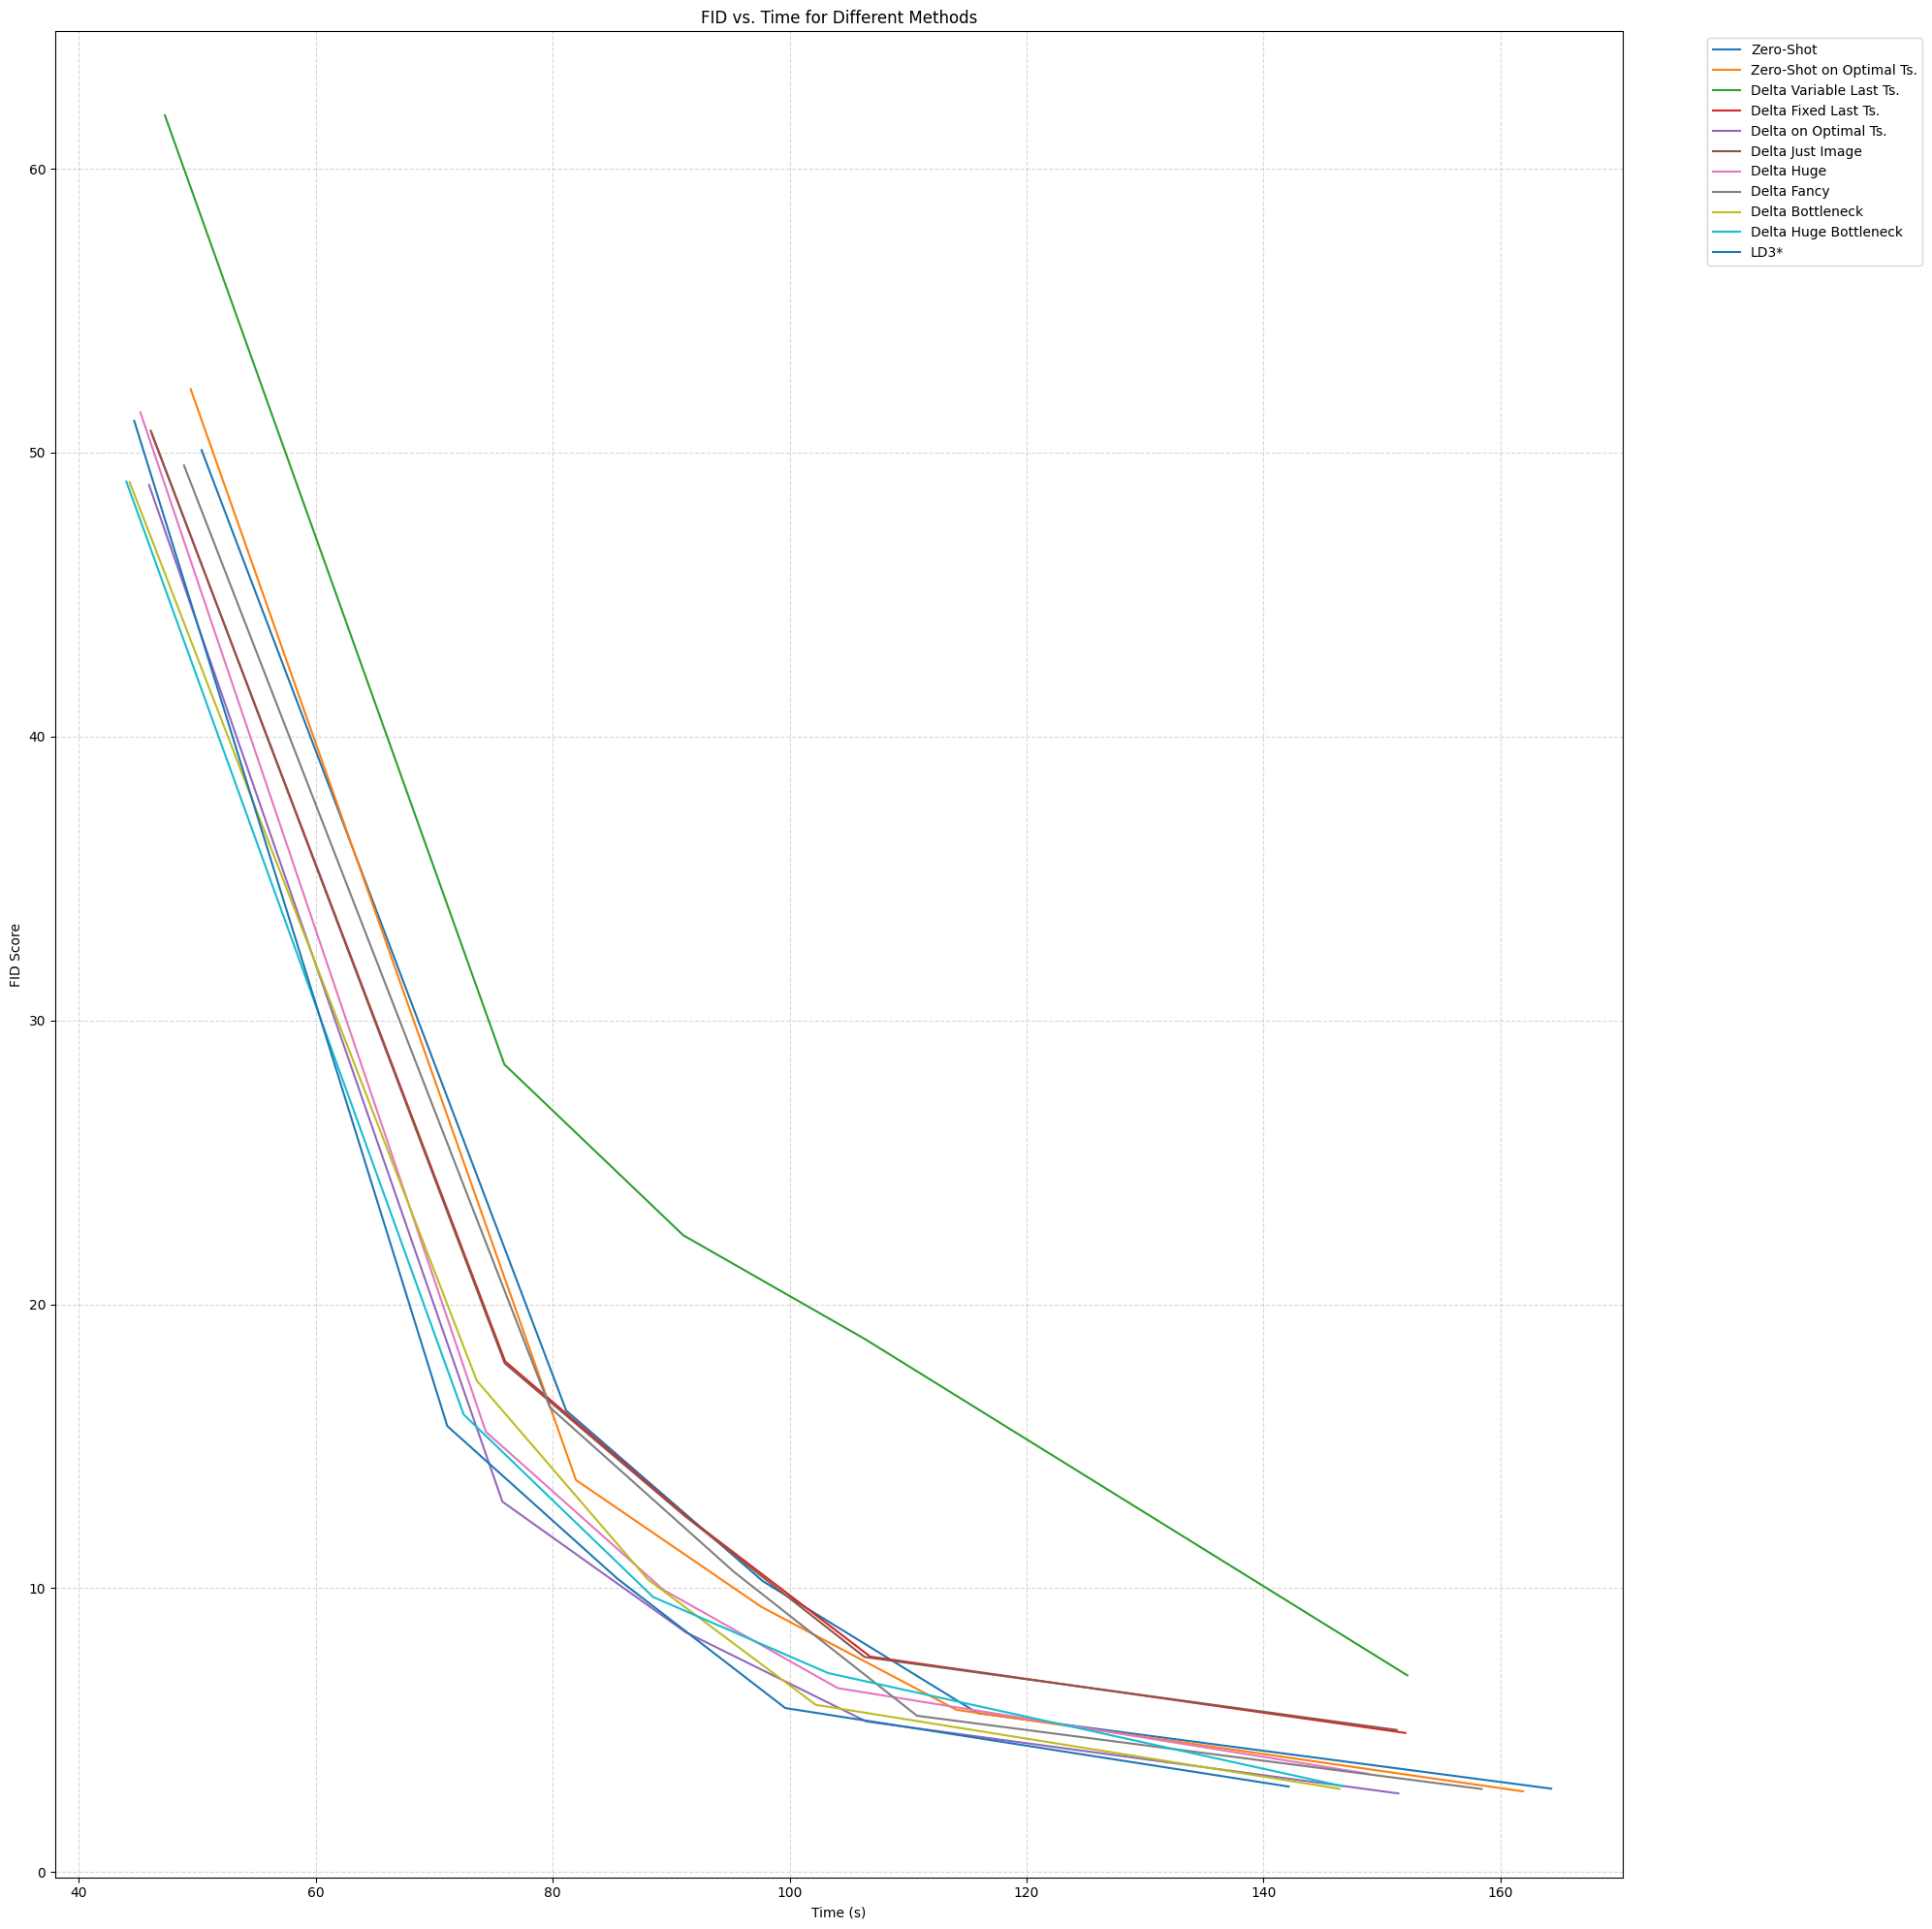

In [68]:
methods = fid_runtime_df.index
timesteps = [3,5,6, 7, 10]

# Construct FID and Time pairs for each method
plt.figure(figsize=(20, 20))
for method in methods:
    fid_scores = [fid_runtime_df.loc[method, f'FID_{t}'] for t in timesteps]
    times = [fid_runtime_df.loc[method, f'Time {t}'] for t in timesteps]
    plt.plot(times, fid_scores, label=method)

plt.xlabel("Time (s)")
plt.ylabel("FID Score")
plt.title("FID vs. Time for Different Methods")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside plot
plt.tight_layout()
plt.show()

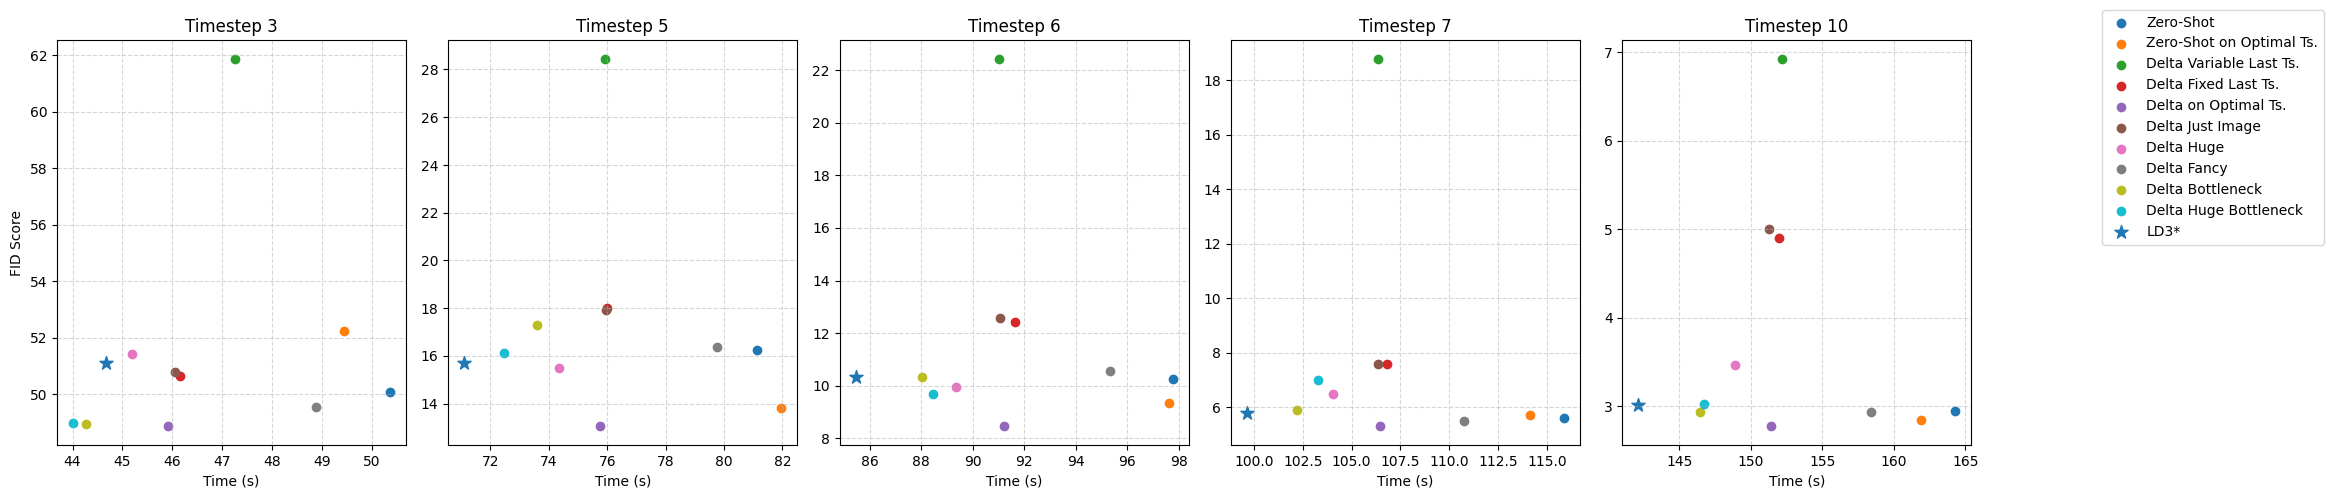

In [66]:
methods = fid_runtime_df.index
timesteps = [3,5,6, 7, 10]

fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 5), sharey=False)
axes = axes.ravel()  # flatten just in case

for i, t in enumerate(timesteps):
    ax = axes[i]
    for method in methods:
        fid = fid_runtime_df.loc[method, f'FID_{t}']
        time = fid_runtime_df.loc[method, f'Time {t}']
        if method == "LD3*":
            ax.scatter(time, fid, label=method, marker = "*", s = 100)
        else:
            ax.scatter(time, fid, label=method)
        

    
    ax.set_title(f"Timestep {t}")
    ax.set_xlabel("Time (s)")
    if i == 0:
        ax.set_ylabel("FID Score")
    ax.grid(True, linestyle='--', alpha=0.5)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

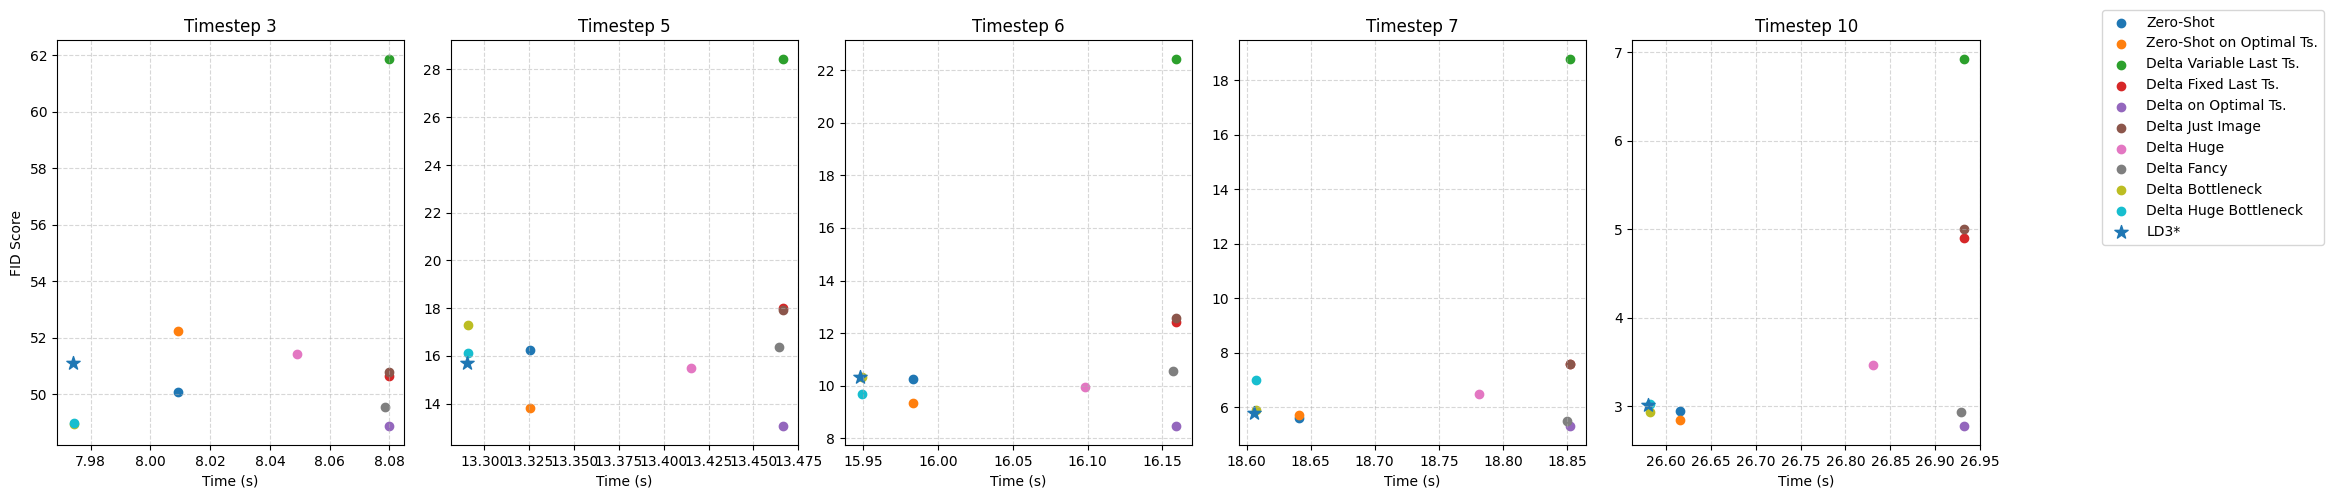

In [73]:
methods = fid_theoretical_runtime_df.index
timesteps = [3,5,6, 7, 10]

fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 5), sharey=False)
axes = axes.ravel()  # flatten just in case

for i, t in enumerate(timesteps):
    ax = axes[i]
    for method in methods:
        fid = fid_theoretical_runtime_df.loc[method, f'FID_{t}']
        time = fid_theoretical_runtime_df.loc[method, f'Time {t}']
        if method == "LD3*":
            ax.scatter(time, fid, label=method, marker = "*", s = 100)
        else:
            ax.scatter(time, fid, label=method)
        

    
    ax.set_title(f"Timestep {t}")
    ax.set_xlabel("Time (s)")
    if i == 0:
        ax.set_ylabel("FID Score")
    ax.grid(True, linestyle='--', alpha=0.5)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Calculating number of steps saved

In [35]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

all_results = pd.read_pickle("all_results.pkl")
all_results



,LPIPS_3,LPIPS_5,LPIPS_6,LPIPS_7,LPIPS_10,FID_3,FID_5,FID_6,FID_7,FID_10
Method,,,,,,,,,,
VP Schedule,0.286,0.167,0.142,0.121,0.089,61.783,25.372,19.421,16.404,12.344
VE Schedule,0.387,0.236,0.178,0.135,0.062,155.934,22.645,12.240,6.358,3.156
iDDPM Schedule,0.338,0.322,0.324,0.316,0.286,59.442,32.149,32.906,32.704,29.453
EDM Schedule,0.320,0.282,0.218,0.185,0.102,58.486,31.667,17.278,11.642,5.979
Global Variable Last Ts.,0.271,0.130,0.095,0.071,0.019,61.274,30.063,19.132,13.414,2.790
Zero-Shot,0.273,0.145,0.113,0.082,0.021,50.087,16.256,10.243,5.598,2.939
Zero-Shot on Optimal Ts.,0.277,0.159,0.124,0.084,0.032,52.236,13.809,9.340,5.713,2.843
Delta Variable Last Ts.,0.263,0.117,0.085,0.059,0.017,61.883,28.451,22.431,18.785,6.929
Delta Fixed Last Ts.,0.270,0.140,0.110,0.080,0.029,50.652,17.989,12.416,7.590,4.901


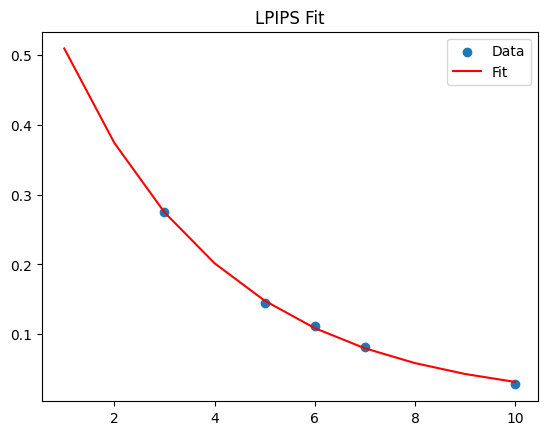

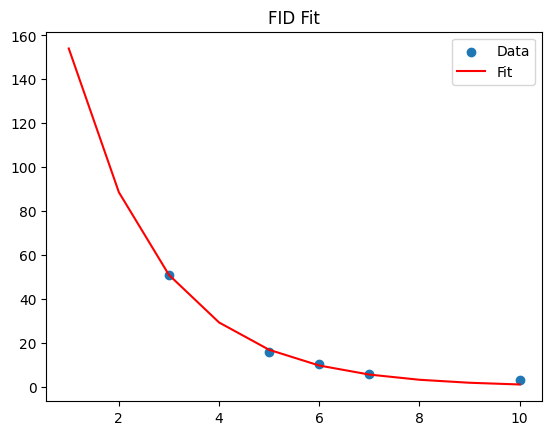

In [36]:
step_values = np.array([3, 5, 6, 7, 10])
all_step_values = np.arange(1, 11, 1)
ld3_lpips_values = all_results.loc["LD3*", ["LPIPS_3", "LPIPS_5", "LPIPS_6", "LPIPS_7", "LPIPS_10"]].to_numpy()
ld3_fid_values = all_results.loc["LD3*", ["FID_3", "FID_5", "FID_6", "FID_7", "FID_10"]].to_numpy()


def expo(x, A, B):
    return A * np.exp(B * x)

def expo_inv(y, A, B):
    return np.log(y / A) / B


popt_lpips, pcov_lpips = curve_fit(expo, step_values, ld3_lpips_values, p0=[3, 1.5])
popt_fid, pcov_fid = curve_fit(expo, step_values, ld3_fid_values, p0=[3, 1.5])


# Plot
plt.scatter(step_values, ld3_lpips_values, label="Data")
plt.plot(all_step_values, expo(all_step_values, *popt_lpips), 'r-', label="Fit")
plt.legend()
plt.title("LPIPS Fit")
plt.show()


# Plot
plt.scatter(step_values, ld3_fid_values, label="Data")
plt.plot(all_step_values, expo(all_step_values, *popt_fid), 'r-', label="Fit")
plt.legend()
plt.title("FID Fit")
plt.show()


In [37]:


optimal_lpips_values = all_results.loc["Optimal Ts.", ["LPIPS_3", "LPIPS_5", "LPIPS_6", "LPIPS_7", "LPIPS_10"]].to_numpy()
popt, pcov = curve_fit(expo, step_values, optimal_lpips_values, p0=[3, 1.5])
for steps, value in zip(step_values, ld3_lpips_values):
    steps_needed = expo_inv(value, *popt)
    percentage_saved = (steps_needed - steps) / steps * 100
    print(f"Saved {percentage_saved:.2f}%")



Saved -14.02%
Saved -21.55%
Saved -25.59%
Saved -26.88%
Saved -26.27%


In [38]:
saved_steps_df = pd.DataFrame(index=["LD3*", "Zero-Shot", "Zero-Shot on Optimal Ts.", "Delta Variable Last Ts.", "Delta Fixed Last Ts.", "Delta on Optimal Ts.", "Delta Just Image", "Delta Huge", "Delta Fancy", "Delta Bottleneck", "Delta Huge Bottleneck", "Optimal Ts."], columns=["3 Steps LPIPS", "5 Steps LPIPS", "6 Steps LPIPS", "7 Steps LPIPS", "10 Steps LPIPS", "Mean LPIPS", "3 Steps FID", "5 Steps FID", "6 Steps FID", "7 Steps FID", "10 Steps FID", "Mean FID"])
saved_steps_df.loc["LD3*"] = 0
saved_steps_df["Mean LPIPS"] = 0
saved_steps_df["Mean FID"] = 0
saved_steps_df



,3 Steps LPIPS,5 Steps LPIPS,6 Steps LPIPS,7 Steps LPIPS,10 Steps LPIPS,Mean LPIPS,3 Steps FID,5 Steps FID,6 Steps FID,7 Steps FID,10 Steps FID,Mean FID
LD3*,0,0,0,0,0,0,0,0,0,0,0,0
Zero-Shot,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Zero-Shot on Optimal Ts.,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta Variable Last Ts.,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta Fixed Last Ts.,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta on Optimal Ts.,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta Just Image,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta Huge,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta Fancy,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
Delta Bottleneck,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0


In [42]:
methods_list = ["Zero-Shot", "Zero-Shot on Optimal Ts.", "Delta Variable Last Ts.", "Delta Fixed Last Ts.", "Delta on Optimal Ts.", "Delta Just Image", "Delta Huge", "Delta Fancy", "Delta Bottleneck", "Delta Huge Bottleneck", "Optimal Ts."]
steps_list = [3, 5, 6, 7, 10]
for metric in ["LPIPS", "FID"]:
    for method in methods_list:
        metric_values = all_results.loc[method, [f"{metric}_{steps}" for steps in steps_list]].to_numpy()
        popt, pcov = curve_fit(expo, steps_list, metric_values, p0=[3, 1.5])
        for n_step, ld3_value in zip(steps_list, ld3_lpips_values if metric == "LPIPS" else ld3_fid_values):
            steps_needed = expo_inv(ld3_value, *popt)
            percentage_saved = (steps_needed - n_step) / n_step * 100
            saved_steps_df.loc[method, f"{n_step} Steps {metric}"] = percentage_saved
        saved_steps_df.loc[method, f"Mean {metric}"] = np.mean(saved_steps_df.loc[method, [f"{n_step} Steps {metric}" for n_step in steps_list]])
saved_steps_df.sort_values(by=["Mean FID"], ascending=False, inplace=True)
saved_steps_df


,3 Steps LPIPS,5 Steps LPIPS,6 Steps LPIPS,7 Steps LPIPS,10 Steps LPIPS,Mean LPIPS,3 Steps FID,5 Steps FID,6 Steps FID,7 Steps FID,10 Steps FID,Mean FID
Delta Variable Last Ts.,-4.136668,-9.201715,-13.145142,-13.97317,-11.845227,-10.460384,17.829796,42.014332,39.432315,44.633537,20.923757,32.966747
Delta Just Image,-1.778436,-0.683051,-3.657814,-3.369447,1.540357,-1.589678,-0.964836,8.985338,5.476401,7.866585,-10.815787,2.109540
Delta Fixed Last Ts.,-2.293566,-0.046304,-2.809183,-2.312951,3.073845,-0.877632,-1.10873,8.874707,5.377026,7.772849,-10.888107,2.005549
LD3*,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000
Delta Bottleneck,0.714038,1.327305,-1.809406,-1.605949,3.206997,0.366597,-2.867279,4.021654,0.209834,2.006067,-15.972918,-2.520528
Delta Fancy,-1.074691,0.060751,-2.929865,-2.633606,2.325365,-0.850409,-2.103355,3.047701,-1.025302,0.442871,-17.462411,-3.420099
Delta Huge Bottleneck,-2.595205,-1.926267,-4.947056,-4.73657,-0.048839,-2.850787,-2.978941,3.013948,-0.908072,0.716512,-17.135202,-3.458351
Zero-Shot,-0.446238,0.850941,-2.132473,-1.806383,3.251198,-0.056591,-1.41145,2.752663,-1.481154,-0.19801,-18.107007,-3.688992
Delta Huge,-1.586212,0.257847,-2.596159,-2.172204,3.071419,-0.605062,0.059438,2.561613,-1.957803,-0.984719,-18.953966,-3.855088
Zero-Shot on Optimal Ts.,1.586599,5.482385,2.874172,3.672135,9.950031,4.713065,0.934135,-0.412314,-5.470594,-5.228062,-22.889809,-6.613329


### Influence if Prior Timestep and Steps Left

In [ ]:
all_ratios = np.zeros((80))
for t in range(0,80):
    delta_timestep_ratio = delta_ltt_model(latent.unsqueeze(0), torch.tensor(t, device=device), torch.tensor(5, device=device))
    all_ratios[t] = delta_timestep_ratio.item()


In [ ]:
plt.scatter(range(len(all_ratios)), all_ratios, color='blue', alpha=0.7)
plt.title("All Ratios at differnt timestep with same latent")
plt.xlabel("Index")
plt.ylabel("Ratio")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()